# Localisation Indoor (IMU + Wi‑Fi) — Rapport technique

Ce notebook présente un pipeline reproductible pour estimer une position 2D (X,Y) à partir de capteurs inertiels (IMU) et de mesures Wi‑Fi (RSSI).

Objectifs du projet
- Concevoir un pipeline complet : import, nettoyage, densification des labels, feature engineering, entraînement et évaluation.
- Comparer approches pointwise (kNN, RandomForest, XGBoost) et séquentielles (LSTM, GRU) en s'assurant d'absence de fuite d'information.
- Proposer et appliquer des métriques pertinentes pour la localisation (erreur radiale, percentiles p68/p90/p95, CDF) et une analyse par session (device/motion).

Jeu de données et contraintes
- Données multi‑fichiers (ESP32, Samsung), trajectoires variées (horizontal, vertical, square...).
- Labels ponctuels interpolés (densification linéaire) — contrôler la qualité des anchors vs densified.
- Forte proportion de NaN sur colonnes Wi‑Fi → sélection top‑K AP requise.

Organisation
1) Import & EDA — exploration et vérifications
2) Prétraitement — filtrage colonnes, timestamp, imputation
3) Feature engineering — rolling IMU, dérivées, sélection Wi‑Fi top‑K
4) Modèles tabulaires & séquentiels — entrainement et évaluation
5) Analyse par trajectoire, synthèse et recommandations

## Étape 1 — Importation et exploration des données

Cette section rassemble le nettoyage des runs précédentes, l'import des fichiers CSV et la consolidation en un DataFrame unifié.

In [1]:
# ============================================================
# SYSTEM & UTILITIES
# ============================================================
import os
import shutil
import io
import zipfile
from pathlib import Path
from math import pi


# ============================================================
# NETWORK & DATA MANIPULATION
# ============================================================
import requests
import pandas as pd
import numpy as np


# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns


# ============================================================
# MACHINE LEARNING — SCIKIT-LEARN
# ============================================================
# Préparation des données
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Modèles
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


# ============================================================
# GRADIENT BOOSTING
# ============================================================
from xgboost import XGBRegressor


# ============================================================
# DEEP LEARNING — PYTORCH
# ============================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Nettoyage des artefacts de runs précédents : suppression des fichiers temporaires générés
if os.path.exists("dataset_trimmed_densified.csv"):
    os.remove("dataset_trimmed_densified.csv")
    print("Removed: dataset_trimmed_densified.csv")
if os.path.exists("dataset_trimmed.csv"):
    os.remove("dataset_trimmed.csv")
    print("Removed: dataset_trimmed.csv")

# 2. Remove the file named `y_targets.csv`
if os.path.exists("y_targets.csv"):
    os.remove("y_targets.csv")
    print("Removed: y_targets.csv")

# 3. Remove the file named `X_preprocessed.csv`
if os.path.exists("X_preprocessed.csv"):
    os.remove("X_preprocessed.csv")
    print("Removed: X_preprocessed.csv")

# 4. Remove the file named `X_feature_engineered.csv`
if os.path.exists("X_feature_engineered.csv"):
    os.remove("X_feature_engineered.csv")
    print("Removed: X_feature_engineered.csv")

# 5. Remove the directory named `csv_from_uncloud` and all its contents.
if os.path.exists("csv_from_uncloud"):
    shutil.rmtree("csv_from_uncloud")
    print("Removed: csv_from_uncloud")

print("Initial cleanup complete.")

Removed: dataset_trimmed_densified.csv
Removed: y_targets.csv
Removed: X_preprocessed.csv
Removed: csv_from_uncloud
Initial cleanup complete.


### Jeu de données — détails d'acquisition  
- Sources : acquisitions multi‑fichiers (ESP32 / Samsung, différents parcours : horizontal, vertical, carré, combiné).  
- Capteurs : Accéléromètre, Gyroscope, Magnétomètre, mesures Wi‑Fi (RSSI par point d'accès).  
- Labels : positions ponctuelles (X,Y) présentes périodiquement → interpolation spatiale pour densifier (label_X,label_Y).  
- Remarques : présence importante de NaN sur certaines colonnes Wi‑Fi, nécessité d'une sélection robuste d'APs (top‑k).

In [2]:
# Constantes (paramètres réutilisés dans le pipeline)
WINDOW_SIZE = 20           # taille de la fenêtre pour les modèles séquentiels
EPOCHS = 100               # nombre max d'époques pour l'entraînement
PATIENCE = 20              # patience pour early stopping
ROLLING_WINDOW_SIZE = 10   # fenêtre rolling pour features IMU
results = []               # stockage des métriques par modèle

# --- Fonctions de téléchargement et extraction ---

def download_zip(url: str) -> bytes:
    """Télécharge le ZIP depuis l'URL et renvoie son contenu en bytes."""
    resp = requests.get(url)
    resp.raise_for_status()
    return resp.content

def extract_csv_from_zip(zip_bytes: bytes, output_dir: Path):
    """
    Extrait tous les fichiers .csv du ZIP dans output_dir.
    Retourne la liste des chemins des CSV extraits.
    """
    csv_paths = []
    with zipfile.ZipFile(io.BytesIO(zip_bytes)) as zf:
        csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
        for name in csv_names:
            extracted_path = zf.extract(name, path=output_dir)
            csv_paths.append(Path(extracted_path))
    return csv_paths

def load_csvs_to_dataframes(csv_paths):
    """
    Charge chaque CSV dans un DataFrame pandas.
    Retourne un dict {nom_fichier_sans_ext: DataFrame}.
    """
    dfs = {}
    for path in csv_paths:
        name_no_ext = os.path.splitext(os.path.basename(path))[0]
        dfs[name_no_ext] = pd.read_csv(path)
    return dfs

# --- Fonctions principales de traitement ---

def infer_device_and_motion(filename: str):
    """
    Déduit 'device' et 'motion' à partir du nom de fichier.
    Fonction robuste même si le nom exact change légèrement.
    """
    name = filename.lower()
    device = "esp32" if "esp32" in name else ("samsung" if "samsung" in name else "unknown")
    if "horizontal" in name:
        motion = "horizontal"
    elif "vertical" in name:
        motion = "vertical"
    elif "square" in name:
        motion = "square"
    elif "combined" in name or "combine" in name:
        motion = "combined"
    else:
        motion = "unknown"
    return device, motion

def add_meta_columns(df: pd.DataFrame, filename: str) -> pd.DataFrame:
    device, motion = infer_device_and_motion(filename)
    df = df.copy()
    df["device"] = device
    df["motion"] = motion
    return df

def densify_spatial_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Densifie spatialement les positions (X, Y) pour toutes les lignes.

    Hypothèses :
    - Les lignes où X et Y sont non NaN sont des "ancres" (points de référence).
    - Entre deux ancres successives, on interpole linéairement X et Y.
    - Avant la première ancre : on copie la 1ère ancre.
    - Après la dernière ancre : on copie la dernière ancre.

    Effets :
    - Crée les colonnes :
        - label_X
        - label_Y
    - Supprime les colonnes originales X et Y (remplacées par label_X / label_Y).
    """

    df = df.copy().reset_index(drop=True)

    # Vérifs de base
    if "X" not in df.columns or "Y" not in df.columns:
        # Pas de colonnes X/Y -> on ne peut pas densifier
        return df

    n = len(df)
    if n == 0:
        return df

    # Colonnes de label densifiées
    df["label_X"] = pd.NA
    df["label_Y"] = pd.NA

    # Ancres : lignes où X et Y ne sont pas NaN
    anchor_mask = df["X"].notna() & df["Y"].notna()
    anchor_idxs = list(df.index[anchor_mask])

    if len(anchor_idxs) == 0:
        # Aucune info de position -> rien à faire
        return df

    if len(anchor_idxs) == 1:
        # Une seule ancre -> tout le monde prend ce label
        i0 = anchor_idxs[0]
        x0 = df.loc[i0, "X"]
        y0 = df.loc[i0, "Y"]
        df["label_X"] = x0
        df["label_Y"] = y0

        # On peut maintenant supprimer X/Y
        df = df.drop(columns=["X", "Y"])
        return df

    # 1) Avant la première ancre : on copie la première
    first = anchor_idxs[0]
    x_first = df.loc[first, "X"]
    y_first = df.loc[first, "Y"]
    df.loc[:first, "label_X"] = x_first
    df.loc[:first, "label_Y"] = y_first

    # 2) Segments entre ancres (interpolation linéaire)
    for i_start, i_end in zip(anchor_idxs[:-1], anchor_idxs[1:]):
        x1 = df.loc[i_start, "X"]
        y1 = df.loc[i_start, "Y"]
        x2 = df.loc[i_end, "X"]
        y2 = df.loc[i_end, "Y"]

        length = i_end - i_start
        if length <= 0:
            continue

        for i in range(i_start, i_end + 1):
            alpha = (i - i_start) / length  # 0 → 1
            xi = x1 + alpha * (x2 - x1)
            yi = y1 + alpha * (y2 - y1)
            df.loc[i, "label_X"] = xi
            df.loc[i, "label_Y"] = yi

    # 3) Après la dernière ancre : on copie la dernière
    last = anchor_idxs[-1]
    x_last = df.loc[last, "X"]
    y_last = df.loc[last, "Y"]
    df.loc[last:, "label_X"] = x_last
    df.loc[last:, "label_Y"] = y_last

    # 4) On supprime X / Y, puisqu'on utilise label_X / label_Y
    df = df.drop(columns=["X", "Y"])

    # Ensure label_X and label_Y are float type
    df["label_X"] = df["label_X"].astype(float)
    df["label_Y"] = df["label_Y"].astype(float)

    return df

def timestamp_to_ms(s: pd.Series) -> pd.Series:
    parts = s.astype(str).str.split(":", expand=True)
    if parts.shape[1] != 4:
        raise ValueError("Timestamp must be in format HH:MM:SS:xx (e.g. 17:24:20:16)")
    hh = pd.to_numeric(parts[0], errors="coerce")
    mm = pd.to_numeric(parts[1], errors="coerce")
    ss = pd.to_numeric(parts[2], errors="coerce")
    xx = pd.to_numeric(parts[3], errors="coerce")
    return ((hh*3600 + mm*60 + ss) * 1000) + (xx * 10)

def build_final_dataset(dfs: dict) -> pd.DataFrame:
    processed = []
    for name, df_item in dfs.items():
        df2 = add_meta_columns(df_item, name)
        df2 = densify_spatial_labels(df2)
        processed.append(df2)
    full = pd.concat(processed, ignore_index=True, sort=True)
    return full

In [3]:
# 1. Define ZIP_URL and OUTPUT_DIR
ZIP_URL = "https://uncloud.univ-nantes.fr/public.php/dav/files/fkkT27xoRkNRmsr/?accept=zip"
OUTPUT_DIR = Path("csv_from_uncloud")

# 2. Download the ZIP file if not already in path
if not os.path.exists("csv_from_uncloud"):
    OUTPUT_DIR.mkdir(exist_ok=True)
    zip_bytes = download_zip(ZIP_URL)
    print("[+] ZIP downloaded.")

    # 3. Extract the CSV files
    csv_paths = extract_csv_from_zip(zip_bytes, OUTPUT_DIR)
    print(f"[+] {len(csv_paths)} CSV files extracted.")

    # 4. Load the extracted CSVs into a dictionary of DataFrames
    dfs_loaded = load_csvs_to_dataframes(csv_paths)
    print(f"[+] {len(dfs_loaded)} DataFrames loaded.")

    # 5. Build the final df DataFrame
    df = build_final_dataset(dfs_loaded)
    print(f"[+] Initial combined DataFrame shape: {df.shape}")

[+] ZIP downloaded.
[+] 10 CSV files extracted.
[+] 10 DataFrames loaded.
[+] Initial combined DataFrame shape: (10256, 43)


## Analyse exploratoire (EDA) — buts et points de contrôle

Buts :
- Vérifier la couverture spatiale des trajectoires et repérer sessions dominantes qui pourraient biaiser l'évaluation.
- Evaluer la présence et la variance des AP Wi‑Fi pour sélectionner un sous‑ensemble informatif (top‑K).
- Rechercher corrélations éventuelles IMU ↔ positions (diagnostic de features utiles).

Points de contrôle à réaliser après exécution :
- Visualiser anchors vs labels densifiés pour 5 trajectoires aléatoires.
- Examiner la distribution de t_ms (dt médian, outliers) par session.
- Construire un tableau AP (presence, variance) et valider le seuil de présence minimal utilisé en FE.

In [4]:
print("\n===============================")
print("1. SHAPE DU DATASET")
print("===============================")
print(f"Nombre de lignes    : {df.shape[0]}")
print(f"Nombre de colonnes  : {df.shape[1]}")


print("\n===============================")
print("2. INFORMATION GENERALE (df.info)")
print("===============================")
df.info()


print("\n===============================")
print("3. STATISTIQUES DESCRIPTIVES (df.describe)")
print("===============================")

# Statistiques numériques uniquement
print("\n--- Colonnes numériques ---")
print(df.describe())

# Stats sur les colonnes catégorielles
print("\n--- Colonnes catégorielles ---")
print(df.describe(include=["object", "category"]))
n_unique_pairs = df[["label_X", "label_Y"]].drop_duplicates().shape[0]
print("Nombre de positions (X,Y) uniques :", n_unique_pairs)



print("\n===============================")
print("4. VALEURS MANQUANTES PAR COLONNE")
print("===============================")

null_counts = df.isna().sum()
null_percent = (null_counts / len(df)) * 100

null_summary = pd.DataFrame({
    "nb_nulls": null_counts,
    "pourcentage_nulls (%)": null_percent
}).sort_values("nb_nulls", ascending=False)

print(null_summary)



1. SHAPE DU DATASET
Nombre de lignes    : 10256
Nombre de colonnes  : 43

2. INFORMATION GENERALE (df.info)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10256 entries, 0 to 10255
Data columns (total 43 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                                                                                                                         

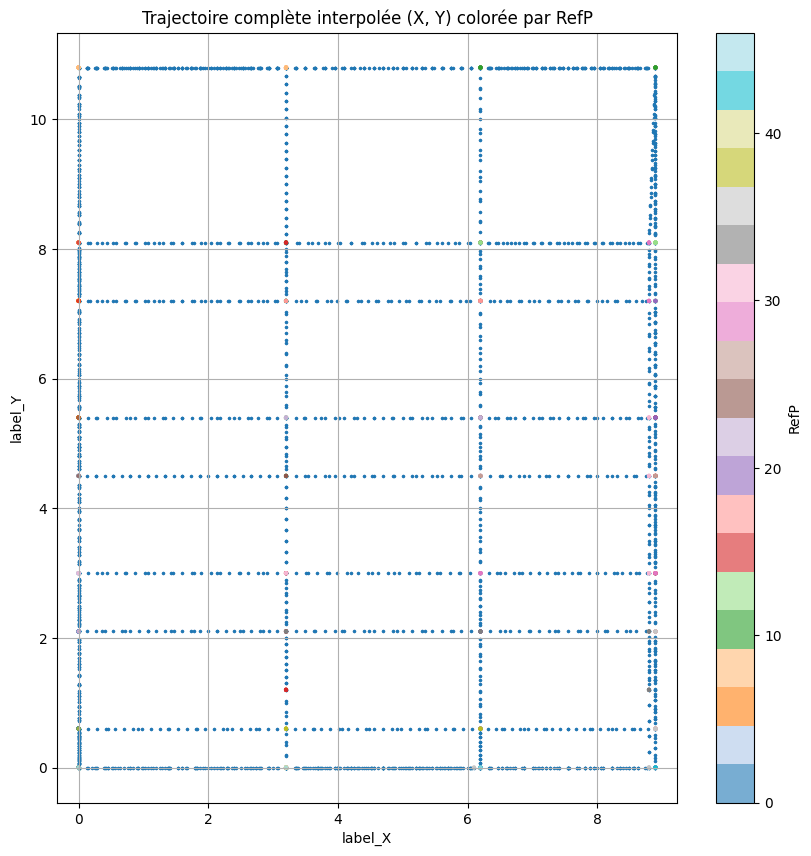

In [5]:
plt.figure(figsize=(10, 10))
plt.title("Trajectoire complète interpolée (X, Y) colorée par RefP")
plt.scatter(df["label_X"], df["label_Y"], s=2, alpha=0.5)
plt.scatter(df["label_X"], df["label_Y"], c=df["RefP"],
            cmap="tab20", s=4, alpha=0.6)
plt.xlabel("label_X")
plt.ylabel("label_Y")
plt.axis("equal")
plt.grid(True)
plt.colorbar(label="RefP")
plt.show(block=False)

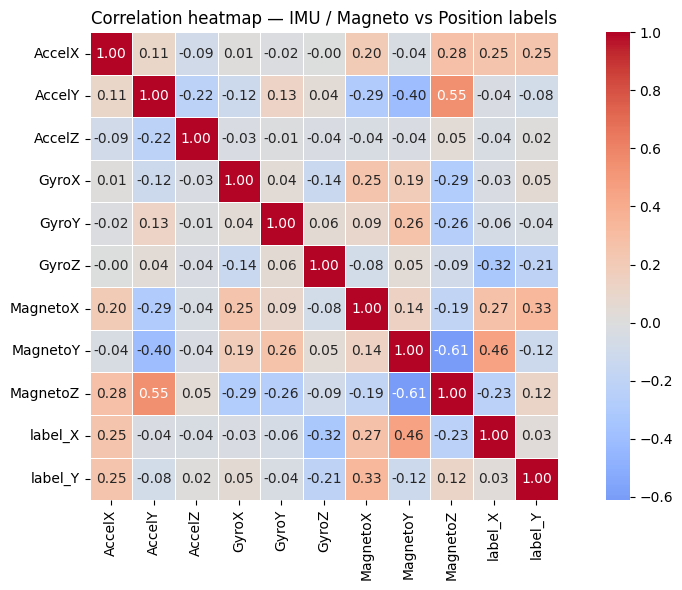

In [6]:
imu_cols = [
    "AccelX", "AccelY", "AccelZ",
    "GyroX", "GyroY", "GyroZ",
    "MagnetoX", "MagnetoY", "MagnetoZ"
]

target_cols = ["label_X", "label_Y"]

corr_cols = imu_cols + target_cols
corr_df = df[corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation heatmap — IMU / Magneto vs Position labels")
plt.tight_layout()
plt.show(block=False)

Nombre de colonnes Wi-Fi : 21
                                AP  presence_ratio   variance
16       eduroam_c8:b5:ad:f3:73:20        0.753120  53.461909
7        eduroam_84:d4:7e:5f:70:60        0.940718  52.677648
10       eduroam_c8:b5:ad:f3:69:c0        0.948128  25.148430
13       eduroam_c8:b5:ad:f3:6b:60        0.803822  19.006677
20       eduroam_f0:5c:19:c3:5d:a0        0.681747  14.899050
17       eduroam_cc:88:c7:03:a4:a0        0.509360  12.902475
19       eduroam_cc:d0:83:a0:e0:a0        0.709048   7.091800
9        eduroam_b4:5d:50:24:17:40        0.007020   4.056338
3   TP-Link_2FA8_9c:53:22:90:2f:a7        0.282761   3.989801
2            Elb_c6:0a:1e:ab:af:c1        0.171217   2.787127


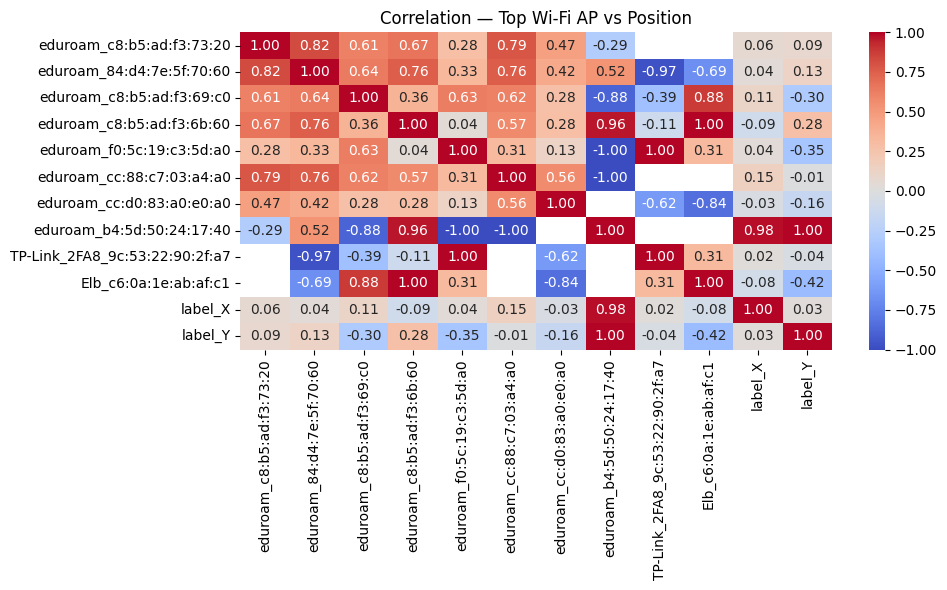

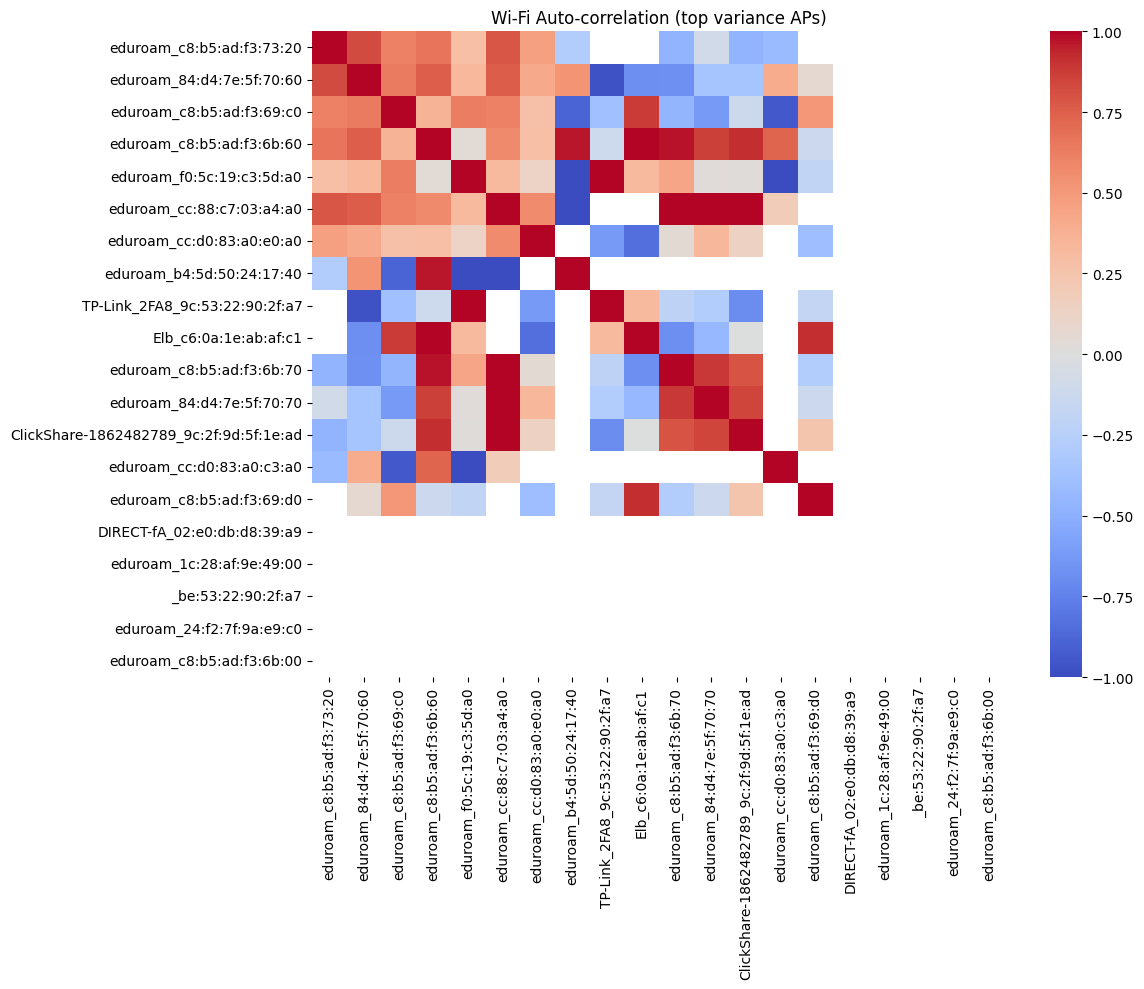

In [7]:
wifi_cols = [c for c in df.columns if any(
    c.lower().startswith(p) for p in [
        "eduroam", "tp-link", "clickshare", "telephone",
        "elb", "direct", "_be"
    ]
)]

print("Nombre de colonnes Wi-Fi :", len(wifi_cols))

wifi_stats = []

for col in wifi_cols:
    present_ratio = df[col].notna().mean()
    variance = df[col].var(skipna=True)
    wifi_stats.append((col, present_ratio, variance))

wifi_stats_df = pd.DataFrame(
    wifi_stats,
    columns=["AP", "presence_ratio", "variance"]
).sort_values("variance", ascending=False)

print(wifi_stats_df.head(10))

top_wifi = wifi_stats_df.head(10)["AP"].tolist()

wifi_corr_cols = top_wifi + ["label_X", "label_Y"]
wifi_corr = df[wifi_corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    wifi_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation — Top Wi-Fi AP vs Position")
plt.tight_layout()
plt.show(block=False)

wifi_subset = wifi_stats_df.head(20)["AP"].tolist()
wifi_auto_corr = df[wifi_subset].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    wifi_auto_corr,
    cmap="coolwarm",
    center=0
)
plt.title("Wi-Fi Auto-correlation (top variance APs)")
plt.tight_layout()
plt.show(block=False)

## Étape 2 — Prétraitement

Étapes réalisées (implémentées dans le code) :
- Suppression des colonnes très partiellement renseignées (>56% NaN).
- Suppression des lignes sans labels (label_X, label_Y).
- Conversion Timestamp → t_ms et imputation robuste (médiane pour capteurs; RSSI traité plus tard).
- Remplacement des valeurs manquantes pour Magneto* par la médiane par colonne.

Raisonnement et risques :
- Densification linéaire des labels est simple et permet d'obtenir des cibles pour l'entraînement, mais peut introduire un biais sur trajectoires courbes → vérifier visuellement.
- Imputation par médiane stabilise les features IMU mais atténue la variabilité ; conserver diagnostics (variance avant/après).

In [ ]:
print("Shape initiale :", df.shape)

# 0) On calcule le taux de nulls AVANT de filtrer les lignes
null_ratio_global = df.isna().mean()

cols_to_keep = null_ratio_global[null_ratio_global <= 0.56].index.tolist()
df_trimmed_1 = df[cols_to_keep]
print("Après suppression colonnes >56% NaN :", df_trimmed_1.shape)

# 1) On enlève maintenant les lignes sans label
df_trimmed = df_trimmed_1.dropna(subset=["label_X", "label_Y"])
print("Après suppression lignes sans label :", df_trimmed.shape)

# 2) Cibles = (X,Y) linear
y = df_trimmed[["label_X", "label_Y"]]
meta = df_trimmed[["device", "label_X", "label_Y"]].reset_index(drop=True)

# 3) on uniformise le vecteur temps pour plus tard
df_trimmed["t_ms"] = timestamp_to_ms(df_trimmed["Timestamp"])

# 3) on enlève tout ce qui est non utile / redondant / lakeage
cols_to_drop = [
    "Index", # doesn't give any informations
    "Timestamp", # new t_ms better
    "vX", "Orientation", "vY", # Always 0.0
    "RefP" # leakage (retiré plus haut car présence < 0.56)
]

df_trimmed = df_trimmed.drop(columns=[c for c in cols_to_drop if c in df_trimmed.columns])

# 3.5) Petit fix pour MagnetoX MagnetoY et MagnetoZ
# Impute missing MagnetoX, MagnetoY, MagnetoZ with their median instead of 0.0
for c in ["MagnetoX", "MagnetoY", "MagnetoZ"]:
    if c in df_trimmed.columns:
        if df_trimmed[c].isnull().any():
            df_trimmed[c] = df_trimmed[c].fillna(df_trimmed[c].median())


# 4) on retire les labels des features
cols_to_forget = [
    "label_X", "label_Y", "RefP", # leakage
]

X = df_trimmed.drop(columns=[c for c in cols_to_forget if c in df_trimmed.columns])

print("X shape :", X.shape)
print("y shape :", y.shape)

# 5) Encodage des variables catégorielles et numériques
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]
print("Colonnes catégorielles :", cat_cols)
print("Colonnes numériques :", num_cols)

# 6) Imputation robuste: apply fillna only to numeric columns
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

# 7) Sauvegarde
df_trimmed.to_csv("dataset_trimmed_densified.csv", index=False)

pd.DataFrame(X, columns=X.columns).to_csv(
    "X_preprocessed.csv", index=False
)
y.to_csv("y_targets.csv", index=False)

print("\n[+] Fichiers sauvegardés :")
print(" - dataset_trimmed_densified.csv")
print(" - X_preprocessed.csv")
print(" - y_targets.csv")

Shape initiale : (10256, 43)
Après suppression colonnes >56% NaN : (10256, 29)
Après suppression lignes sans label : (10156, 29)
X shape : (10156, 23)
y shape : (10156, 2)
Colonnes catégorielles : ['device', 'motion']
Colonnes numériques : ['AccelX', 'AccelY', 'AccelZ', 'ClickShare-1862482789_9c:2f:9d:5f:1e:ad', 'GyroX', 'GyroY', 'GyroZ', 'MagnetoX', 'MagnetoY', 'MagnetoZ', 'eduroam_84:d4:7e:5f:70:60', 'eduroam_84:d4:7e:5f:70:70', 'eduroam_c8:b5:ad:f3:69:c0', 'eduroam_c8:b5:ad:f3:69:d0', 'eduroam_c8:b5:ad:f3:6b:60', 'eduroam_c8:b5:ad:f3:6b:70', 'eduroam_c8:b5:ad:f3:73:20', 'eduroam_cc:88:c7:03:a4:a0', 'eduroam_cc:d0:83:a0:e0:a0', 'eduroam_f0:5c:19:c3:5d:a0', 't_ms']


C:\Users\flavi\AppData\Local\Temp\ipykernel_12740\3581788088.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed["t_ms"] = timestamp_to_ms(df_trimmed["Timestamp"])



[+] Fichiers sauvegardés :
 - dataset_trimmed_densified.csv
 - X_preprocessed.csv
 - y_targets.csv


### Régression linéaire

Modèle de base pour évaluer la complexité ajoutée par rapport à un modèle linéaire simple.

In [9]:
X_train, X_test, y_train, y_test_raw, meta_train, meta_test = train_test_split(
    X, y, meta, test_size=0.3, random_state=42
)

# Ensure X_train and X_test are DataFrames with column names
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols),
    ]
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test_raw.shape)

# Baseline : Linear Regression
linreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred_lr = linreg.predict(X_test)


Train : (7109, 23) (7109, 2)
Test  : (3047, 23) (3047, 2)


=== Régression Linéaire ===
Erreur moyenne (m) : 3.301082204846627
Erreur médiane (m) : 3.126743931215333
90e percentile (m) : 5.384640034720598


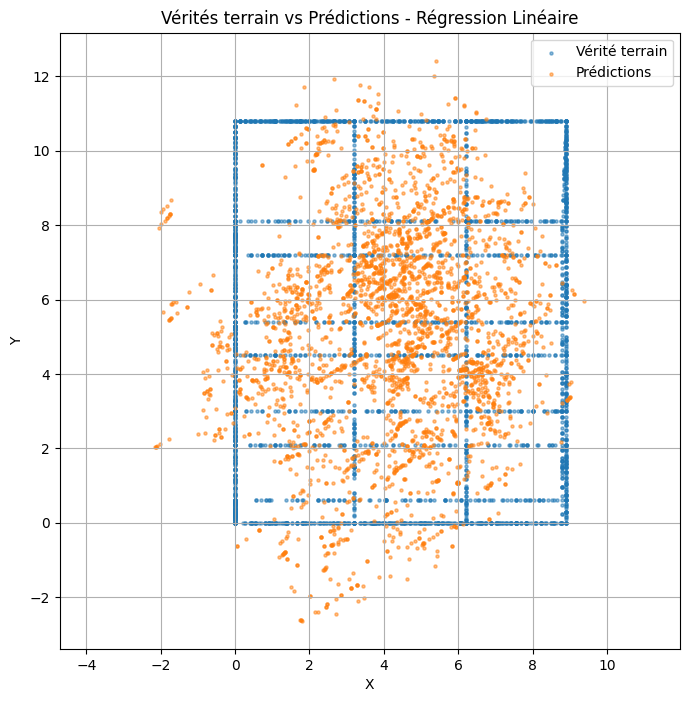

In [10]:
# Analyse des résultats de la baseline
print("=== Régression Linéaire ===")
errors = np.linalg.norm(y_test_raw.values - y_pred_lr, axis=1)

print("Erreur moyenne (m) :", errors.mean())
print("Erreur médiane (m) :", np.median(errors))
print("90e percentile (m) :", np.percentile(errors, 90))

plt.figure(figsize=(8, 8))
plt.scatter(y_test_raw["label_X"], y_test_raw["label_Y"],
            s=5, alpha=0.5, label="Vérité terrain")
plt.scatter(y_pred_lr[:,0], y_pred_lr[:,1],
            s=5, alpha=0.5, label="Prédictions")

plt.legend()
plt.title("Vérités terrain vs Prédictions - Régression Linéaire")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)
plt.show(block=False)

Grâce à ce premier test, nous savons que le problème n'est pas linéaire et que les données brutes ne seront pas suffisantes pour ce genre d'analyse.

## Étape 3 — Feature engineering

Le feature engineering a pour objectif de transformer les signaux bruts (WiFi et capteurs inertiels) en des représentations exploitables par les modèles d’apprentissage, tout en limitant le bruit et les risques de fuite de données.

Les transformations appliquées visent à améliorer la stabilité des modèles et leur capacité de généralisation, sans introduire de contraintes spatiales explicites.

---

### Signaux WiFi

Les traitements appliqués incluent :
- la sélection d’un sous-ensemble de points d’accès (top-k) afin de réduire la dimension et la sparsité,
- l’encodage des niveaux RSSI et de la présence des points d’accès,
- la suppression des signaux peu fréquents,
- la normalisation des variables numériques.

Ces traitements visent à conserver les signatures spatiales dominantes du WiFi tout en réduisant la variabilité instantanée du signal.

---

### Capteurs inertiels

Les signaux inertiels sont utilisés sous forme brute, complétés par :
- des dérivées temporelles simples,
- des statistiques glissantes (moyenne et écart-type).

Ces transformations apportent une information dynamique locale sur le mouvement, sans recourir à une intégration explicite (vitesse ou position), afin de limiter l’accumulation d’erreurs.

---

### Variables contextuelles

Les variables contextuelles, telles que le type de mouvement (`motion`), sont encodées par one-hot encoding.  
Le champ `device` est contrôlé ou exclu lors des tests cross-device afin d’éviter toute information non disponible en situation réelle.


In [11]:
# --- Fonctions d'évaluation : métriques adaptées à la localisation 2D ---
def evaluate_regression(y_true, y_pred, name="model"):
    """
    Métriques utiles pour la localisation 2D.
    Entrées y_true, y_pred : matrices (N,2) contenant (X,Y).
    Retour : dictionnaire contenant RMSE, MAE, percentiles (p68,p90,p95), couverture P(err<seuil), etc.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    if y_true.shape != y_pred.shape or y_true.ndim != 2 or y_true.shape[1] != 2:
        raise ValueError(f"y_true et y_pred doivent être (N,2). Got {y_true.shape=} {y_pred.shape=}")

    # erreurs par axe
    ex = y_pred[:, 0] - y_true[:, 0]
    ey = y_pred[:, 1] - y_true[:, 1]

    # erreur radiale (distance euclidienne)
    err = np.sqrt(ex**2 + ey**2)

    # RMSE par axe + global 2D
    rmse_x = np.sqrt(np.mean(ex**2))
    rmse_y = np.sqrt(np.mean(ey**2))
    rmse_2d = np.sqrt(np.mean(err**2))          # = sqrt(mean(ex^2+ey^2))

    # MAE par axe + radial
    mae_x = np.mean(np.abs(ex))
    mae_y = np.mean(np.abs(ey))
    mae_2d = np.mean(err)

    # biais (erreur moyenne signée) par axe
    bias_x = np.mean(ex)
    bias_y = np.mean(ey)

    # "R95" : rayon contenant 95% des erreurs (super parlant en indoor)
    # (souvent reporté comme CEP95/R95)
    r50 = np.percentile(err, 50)
    r68 = np.percentile(err, 68)               # ~1-sigma si gaussien
    r90 = np.percentile(err, 90)
    r95 = np.percentile(err, 95)
    r99 = np.percentile(err, 99)

    # scores de couverture : P(error < seuil)
    thresholds = [0.25, 0.5, 1.0, 2.0]          # à ajuster selon le cahier des charges
    cov = {f"p_err_lt_{t}m": float(np.mean(err <= t)) for t in thresholds}

    # erreur max + n (utile pour voir les outliers)
    max_err = float(np.max(err))
    n = int(err.shape[0])

    out = {
        "model": name,
        "n": n,

        # global
        "rmse_2d_m": float(rmse_2d),
        "mae_2d_m": float(mae_2d),
        "median_err_m": float(r50),
        "errors_radial_m": err,

        # percentiles / fiabilité
        "p68_err_m": float(r68),
        "p90_err_m": float(r90),
        "p95_err_m": float(r95),
        "p99_err_m": float(r99),
        "max_err_m": max_err,

        # par axe (diagnostic)
        "rmse_x_m": float(rmse_x),
        "rmse_y_m": float(rmse_y),
        "mae_x_m": float(mae_x),
        "mae_y_m": float(mae_y),
        "bias_x_m": float(bias_x),
        "bias_y_m": float(bias_y),
    }

    out.update(cov)
    return out

def feature_engineering_best(
    df_in: pd.DataFrame,
    *,
    # IMU
    imu_cols=("AccelX","AccelY","AccelZ","GyroX","GyroY","GyroZ","MagnetoX","MagnetoY","MagnetoZ"),
    time_col="t_ms",

    # Rolling features
    add_rolling=True,                                   # calcule et ajoute les features *_roll_*
    rolling_window_size=ROLLING_WINDOW_SIZE,            # ROLLING_WINDOW_SIZE
    rolling_group_cols=("device","motion"),
    rolling_imu_cols=("AccelX","AccelY","AccelZ","GyroX","GyroY","GyroZ"),
    rolling_stats=("mean","var","min","max"),

    # Diff/derivatives
    add_diff=True,
    add_dt_derivative=True,
    eps_dt_ms=1.0,

    # Wi-Fi
    wifi_prefixes=("eduroam","tp-link", "clickshare", "telephone","elb","direct","_be"),
    rssi_missing=-100.0,
    wifi_min_presence=0.05,
    wifi_topk=10,

    # NaN handling
    fill_numeric_with="median",        # "median" ou "zero"
    verbose=True
):
    """
    Retourne:
      df_fe: dataframe enrichi (copie)
      X_fe: features finales
      y: labels (label_X,label_Y) si présents sinon None
      meta: dict utile (cols Wi-Fi retenues, stats NaN, etc.)
      feature_cols: liste finale des features (ordre)
    """

    df = df_in.copy()

    # ---------- 0) Sanity checks ----------
    if time_col not in df.columns:
        raise ValueError(f"Il manque la colonne temps '{time_col}'. Génère-la avant (Timestamp -> t_ms).")

    # garde uniquement IMU présentes
    imu_cols = [c for c in imu_cols if c in df.columns]
    if len(imu_cols) == 0:
        raise ValueError("Aucune colonne IMU trouvée (Accel/Gyro/Magneto). Vérifie les noms de colonnes.")

    # ---------- Helpers ----------
    def _fill_series(s: pd.Series) -> pd.Series:
        if not s.isna().any():
            return s
        if fill_numeric_with == "median":
            med = s.median()
            if pd.isna(med):  # colonne entièrement NaN -> fallback 0
                print("Erreur de méthode !")
                med = 0.0
            return s.fillna(med)
        elif fill_numeric_with == "zero":
            return s.fillna(0.0)
        else:
            raise ValueError("fill_numeric_with doit être 'median' ou 'zero'")

    # ---------- 1) NaN handling de base (capteurs) ----------
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[time_col] = _fill_series(df[time_col])

    for c in imu_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = _fill_series(df[c])

    # Optionnel : trier pour que rolling/diff soient temporellement corrects
    if all(gc in df.columns for gc in rolling_group_cols):
        df = df.sort_values(list(rolling_group_cols) + [time_col], kind="mergesort").reset_index(drop=True)
    else:
        df = df.sort_values([time_col], kind="mergesort").reset_index(drop=True)

    # ---------- 2) Rolling features ----------
    roll_cols = []
    if add_rolling:
        # garde uniquement les colonnes IMU demandées et présentes
        rolling_imu_cols_present = [c for c in rolling_imu_cols if c in df.columns]
        if len(rolling_imu_cols_present) > 0:
            if verbose:
                print(f"[FE] Génération des rolling features (window={rolling_window_size}) sur {len(rolling_imu_cols_present)} colonnes IMU...")

            grp = df.groupby(list(rolling_group_cols), sort=False) if all(gc in df.columns for gc in rolling_group_cols) else None

            def _roll_transform(series: pd.Series, fn: str) -> pd.Series:
                r = series.rolling(window=rolling_window_size, min_periods=1)
                if fn == "mean":
                    return r.mean()
                if fn == "var":
                    return r.var()
                if fn == "min":
                    return r.min()
                if fn == "max":
                    return r.max()
                raise ValueError(f"rolling stat inconnue: {fn}")

            for col in rolling_imu_cols_present:
                for stat in rolling_stats:
                    newc = f"{col}_roll_{stat}"
                    if grp is not None:
                        df[newc] = grp[col].transform(lambda x, st=stat: _roll_transform(x, st))
                    else:
                        df[newc] = _roll_transform(df[col], stat)
                    roll_cols.append(newc)

            # Fill NaN post-rolling:
            # - var -> 0
            # - mean/min/max -> médiane colonne (robuste)
            for c in roll_cols:
                df[c] = pd.to_numeric(df[c], errors="coerce")
                if "roll_var" in c:
                    df[c] = df[c].fillna(0.0)
                else:
                    med = df[c].median()
                    if pd.isna(med):
                        med = 0.0
                    df[c] = df[c].fillna(med)

            if verbose:
                print(f"[FE] Nouvelles rolling features créées: {len(roll_cols)}")

    # ---------- 3) IMU derivatives ----------
    dt_ms = df[time_col].diff()
    dt_med = dt_ms.median()
    dt_ms = dt_ms.fillna(dt_med if not pd.isna(dt_med) else 10.0)
    dt_ms = dt_ms.clip(lower=eps_dt_ms)
    dt_s = dt_ms / 1000.0

    deriv_cols = []
    if add_diff:
        for c in imu_cols:
            newc = f"{c}_diff"
            df[newc] = df[c].diff().fillna(0.0)
            deriv_cols.append(newc)

    if add_dt_derivative:
        for c in imu_cols:
            newc = f"{c}_dt"
            df[newc] = (df[c].diff() / dt_s).replace([np.inf, -np.inf], np.nan)
            df[newc] = _fill_series(df[newc]).fillna(0.0)
            deriv_cols.append(newc)

    # ---------- 4) Wi-Fi Top-K AP ----------
    wifi_all_cols = [c for c in df.columns if any(str(c).lower().startswith(p) for p in wifi_prefixes)]
    topk_wifi_cols = []
    if len(wifi_all_cols) > 0:
        wifi_raw = df[wifi_all_cols].copy()
        presence_rate = wifi_raw.notna().mean()
        wifi_filled = wifi_raw.fillna(rssi_missing)
        wifi_var = wifi_filled.var()

        score = (wifi_var * presence_rate)
        score = score[presence_rate >= wifi_min_presence].sort_values(ascending=False)
        topk_wifi_cols = score.head(wifi_topk).index.tolist()

        for c in topk_wifi_cols:
            df[c] = pd.to_numeric(wifi_filled[c], errors="coerce").fillna(rssi_missing).astype(float)

    # ---------- 5) Assemble features finales ----------
    feature_cols = [time_col] + imu_cols
    feature_cols += deriv_cols
    feature_cols += roll_cols
    feature_cols += topk_wifi_cols

    # dédoublonne, garde ordre
    seen = set()
    feature_cols = [c for c in feature_cols if (c in df.columns) and (c not in seen and not seen.add(c))]

    X_fe = df[feature_cols].copy()

    # ---------- 7) NaN final check + autofill ----------
    for c in topk_wifi_cols:
        if X_fe[c].isna().any():
            X_fe[c] = X_fe[c].fillna(rssi_missing)

    for c in X_fe.columns:
        if X_fe[c].dtype.kind in "biufc" and X_fe[c].isna().any():
            X_fe[c] = _fill_series(X_fe[c])

    nan_total = int(X_fe.isna().sum().sum())

    # labels si présents
    y = None
    if {"label_X","label_Y"}.issubset(df.columns):
        y = df[["label_X","label_Y"]].copy()

    meta = {
        "imu_cols": imu_cols,
        "derivative_cols": deriv_cols,
        "roll_cols": roll_cols,
        "roll_created_cols": roll_cols,
        "wifi_all_cols_count": len(wifi_all_cols),
        "wifi_topk_cols": topk_wifi_cols,
        "feature_cols_final": feature_cols,
        "nan_total_in_X_fe": nan_total,
        "rolling_window_size": rolling_window_size,
        "rolling_group_cols": rolling_group_cols,
    }

    # logging for debug
    if verbose:
        print(f"[FE] IMU cols: {len(imu_cols)} | deriv: {len(deriv_cols)} | roll: {len(roll_cols)} (created={len(roll_cols)})")
        print(f"[FE] Wi-Fi all: {len(wifi_all_cols)} | topK: {len(topk_wifi_cols)} (K={wifi_topk})")
        print(f"[FE] X_fe shape: {X_fe.shape} | NaN total: {nan_total}")
        print(meta)

    return df, X_fe, y, meta, feature_cols


# Device-wise RSSI calibration utilities
def get_wifi_columns(df, prefixes=("eduroam","tp-link","clickshare","telephone","elb","direct","_be")):
    return [c for c in df.columns if any(str(c).lower().startswith(p) for p in prefixes)]

def calibrate_rssi_by_device(df, method='median_offset'):
    """Return a copy of df with calibrated RSSI columns.
    method: 'median_offset' or 'zscore'
    Adds suffixes: _rssi_med_adj or _rssi_z
    """
    df = df.copy()
    wifi_cols = get_wifi_columns(df)
    if len(wifi_cols) == 0:
        print('No WiFi columns detected for calibration.'); return df
    devs = df['device'].unique() if 'device' in df.columns else []
    for col in wifi_cols:
        if method == 'median_offset':
            # compute device median and subtract per-device median
            med_by_dev = df.groupby('device')[col].median()
            adj_col = col + '_rssi_med_adj'
            df[adj_col] = df[col].copy()
            for d in med_by_dev.index:
                mask = df['device'] == d
                df.loc[mask, adj_col] = df.loc[mask, col] - med_by_dev.loc[d]
        elif method == 'zscore':
            z_col = col + '_rssi_z'
            df[z_col] = df[col].copy()
            mean_by_dev = df.groupby('device')[col].transform('mean')
            std_by_dev = df.groupby('device')[col].transform('std').replace(0, 1.0)
            df[z_col] = (df[col] - mean_by_dev) / std_by_dev
        else:
            raise ValueError('Unknown method')
    return df

### Résultats attendus du feature engineering

Les transformations appliquées ne visent pas à résoudre à elles seules le problème de localisation indoor, mais à :

- Améliorer la stabilité des prédictions pointwise.
- Réduire la variance des erreurs sur les sessions courantes.
- Faciliter l’apprentissage des modèles séquentiels en fournissant un contexte temporel local plus informatif.
- Mettre en évidence les limites structurelles du signal disponible, notamment en situation cross-device.

Les résultats montrent que le feature engineering permet d’extraire des informations pertinentes pour la localisation, tout en confirmant que l’absence de contraintes spatiales explicites (carte, topologie) constitue une limite fondamentale du système.

In [12]:
# ------------------------------------------------------------
# Préparation des données — train/test split
# ------------------------------------------------------------

df0 = df_trimmed.copy()
df0["session_id"] = df0["device"].astype(str) + "__" + df0["motion"].astype(str)

groups = df0["session_id"].to_numpy()
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(df0, groups=groups))

df_train = df0.iloc[train_idx].copy().reset_index(drop=True)
df_test  = df0.iloc[test_idx].copy().reset_index(drop=True)

print("Sessions d'entraînement:", df_train["session_id"].nunique(), sorted(df_train["session_id"].unique())[:5])
print("Sessions de test     :", df_test["session_id"].nunique(),  sorted(df_test["session_id"].unique())[:5])


# --- FE train ---
df_train_fe, X_train_fe, y_train_df, meta_train, feature_cols_train = feature_engineering_best(
    df_train,
    wifi_topk=10,
    wifi_min_presence=0.05,
    add_diff=True,
    add_dt_derivative=True,
    add_rolling=True,
    verbose=True
)

# labels train (alignés avec X_train_fe)
y_train = df_train_fe[["label_X","label_Y"]].to_numpy()

# calibration
df_train_fe = calibrate_rssi_by_device(df_train_fe, method="median_offset")
print('Calibration (median_offset) applied to df_train_fe')

# --- FE test ---
df_test_fe, X_test_fe, y_test_df, meta_test, feature_cols_test = feature_engineering_best(
    df_test,
    wifi_topk=10,
    wifi_min_presence=0.05,
    add_diff=True,
    add_dt_derivative=True,
    add_rolling=True,
    verbose=False
)

y_test = df_test_fe[["label_X","label_Y"]].to_numpy()

df_test_fe = calibrate_rssi_by_device(df_test_fe, method="median_offset")
print('Calibration (median_offset) applied to df_test_fe')


# --- alignement strict pour éviter 62 vs 64 ---
X_train_fe = pd.concat([X_train_fe, df_train[['device', 'motion']]], axis=1)
X_test_fe = pd.concat([X_test_fe, df_test_fe[["device","motion"]]], axis=1)
X_test_fe = X_test_fe.reindex(columns=X_train_fe.columns, fill_value=0.0)

print(f"Shape of X_train_fe: {X_train_fe.shape}")
print(f"Shape of X_test_fe: {X_test_fe.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# 3. Identify numerical and categorical columns
# Numerical columns are all columns in X_train_fe, which includes base IMU, Magneto, t_ms, rolling IMU and Top-K WiFi
num_cols = [c for c in X_train_fe.columns if c not in cat_cols]

# Categorical columns are 'device' and 'motion'
cat_cols = ['device', 'motion']

print(f"Numerical columns for non-sequential models: {num_cols}")
print(f"Categorical columns for non-sequential models: {cat_cols}")

# 4. Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
    ]
)

print("ColumnTransformer 'preprocessor' created successfully.")

Sessions d'entraînement: 5 ['esp32__square', 'esp32__vertical', 'samsung__combined', 'samsung__square', 'samsung__vertical']
Sessions de test     : 3 ['esp32__combined', 'esp32__horizontal', 'samsung__horizontal']
[FE] Génération des rolling features (window=10) sur 6 colonnes IMU...
[FE] Nouvelles rolling features créées: 24
[FE] IMU cols: 9 | deriv: 18 | roll: 24 (created=24)
[FE] Wi-Fi all: 11 | topK: 10 (K=10)
[FE] X_fe shape: (7081, 62) | NaN total: 0
{'imu_cols': ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnetoX', 'MagnetoY', 'MagnetoZ'], 'derivative_cols': ['AccelX_diff', 'AccelY_diff', 'AccelZ_diff', 'GyroX_diff', 'GyroY_diff', 'GyroZ_diff', 'MagnetoX_diff', 'MagnetoY_diff', 'MagnetoZ_diff', 'AccelX_dt', 'AccelY_dt', 'AccelZ_dt', 'GyroX_dt', 'GyroY_dt', 'GyroZ_dt', 'MagnetoX_dt', 'MagnetoY_dt', 'MagnetoZ_dt'], 'roll_cols': ['AccelX_roll_mean', 'AccelX_roll_var', 'AccelX_roll_min', 'AccelX_roll_max', 'AccelY_roll_mean', 'AccelY_roll_var', 'AccelY_roll_min', 'Ac

### Sanity check

In [13]:
# Sanity checks and diagnostics
def sanity_checks(df, name='df'):
    print(f'--- Sanity checks: {name} ---')
    print('shape:', df.shape)
    nulls = df.isna().sum()
    pct_null = (nulls / len(df) * 100).sort_values(ascending=False)
    print('Top 10 columns by % NaN:')
    print(pct_null.head(10))
    if 't_ms' in df.columns:
        dt = df['t_ms'].diff().dropna()
        print('dt ms — median:', dt.median(), 'mean:', dt.mean(), 'min:', dt.min(), 'max:', dt.max())
    if 'device' in df.columns and 'motion' in df.columns:
        print('Unique sessions (device__motion):', df.groupby(['device','motion']).ngroups)
    wifi_cols = get_wifi_columns(df)
    if len(wifi_cols) > 0:
        pres = df[wifi_cols].notna().mean().sort_values(ascending=False)
        print('Top WiFi presence (top 10):')
        print(pres.head(10))
    print('--- end checks ---')

# Run sanity checks if df_trimmed and X_preprocessed exist
try:
    if 'df_trimmed' in globals():
        sanity_checks(df_trimmed, 'df_trimmed')
    if 'df_train_fe' in globals():
        sanity_checks(df_train_fe, 'df_train_fe')
    if 'df_test_fe' in globals():
        sanity_checks(df_test_fe, 'df_test_fe')
except Exception as e:
    print('Sanity checks error:', e)

--- Sanity checks: df_trimmed ---
shape: (10156, 25)
Top 10 columns by % NaN:
ClickShare-1862482789_9c:2f:9d:5f:1e:ad    54.706577
eduroam_c8:b5:ad:f3:69:d0                  54.706577
eduroam_c8:b5:ad:f3:6b:70                  54.706577
eduroam_84:d4:7e:5f:70:70                  54.706577
eduroam_cc:88:c7:03:a4:a0                  48.562426
eduroam_f0:5c:19:c3:5d:a0                  31.153998
eduroam_cc:d0:83:a0:e0:a0                  28.397007
eduroam_c8:b5:ad:f3:73:20                  23.946436
eduroam_c8:b5:ad:f3:6b:60                  18.826310
eduroam_84:d4:7e:5f:70:60                   5.001969
dtype: float64
dt ms — median: 170.0 mean: -4807.590349581487 min: -50781560.0 max: 51134590.0
Unique sessions (device__motion): 8
Top WiFi presence (top 10):
eduroam_c8:b5:ad:f3:69:c0                  0.957464
eduroam_84:d4:7e:5f:70:60                  0.949980
eduroam_c8:b5:ad:f3:6b:60                  0.811737
eduroam_c8:b5:ad:f3:73:20                  0.760536
eduroam_cc:d0:83:a0:e0:a0

## Étape 4 — Modèles tabulaires

Approche : entraîner des modèles pointwise sur les features agrégées (rolling IMU, dérivées, top‑K Wi‑Fi) avec un préprocesseur (scaler + OHE). Les cibles sont label_X et label_Y (régression multivariée ou modèles séparés pour X et Y).

Modèles testés : LinearRegression (baseline), kNN (fingerprinting), RandomForest, XGBoost.

Attentes et diagnostics :
- Attente : RF / XGBoost surpassent la régression linéaire ; kNN performant localement mais sensible au bruit RSSI.
- En cas de résultats inattendus : rechercher fuite d'information, vérifier alignement colonnes train/test, inspecter importances et résidus par session.

### kNN

In [14]:
print("\nTraining kNN with FE...")
knn_pipeline_fe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsRegressor(
        n_jobs=-1
    ))
])
knn_pipeline_fe.fit(X_train_fe, y_train)
y_pred_knn_fe = knn_pipeline_fe.predict(X_test_fe)

res_knn_fe = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred_knn_fe,
    name="kNN_FE"
)
results.append(res_knn_fe)

print("kNN FE evaluated.")


Training kNN with FE...


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


kNN FE evaluated.


### Random Forest

In [15]:
print("\nTraining Random Forest with FE...")
rf_pipeline_fe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])
rf_pipeline_fe.fit(X_train_fe, y_train)
y_pred_rf_fe = rf_pipeline_fe.predict(X_test_fe)

res_rf_fe = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred_rf_fe,
    name="RandomForest_FE"
)
results.append(res_rf_fe)

print("Random Forest FE evaluated.")


Training Random Forest with FE...
Random Forest FE evaluated.


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### XGBoost

In [16]:
print("\nTraining XGBoost with FE...")
# XGBoost for label_X
xgb_x_pipeline_fe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=600,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ))
])
xgb_x_pipeline_fe.fit(X_train_fe, y_train[:,0])
pred_x_fe = xgb_x_pipeline_fe.predict(X_test_fe)

# XGBoost for label_Y
xgb_y_pipeline_fe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=600,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ))
])
xgb_y_pipeline_fe.fit(X_train_fe, y_train[:,1])
pred_y_fe = xgb_y_pipeline_fe.predict(X_test_fe)

y_pred_xgb_fe = np.column_stack([pred_x_fe, pred_y_fe])

res_xgb_fe = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred_xgb_fe,
    name="XGBoost_FE"
)
results.append(res_xgb_fe)

print("XGBoost FE evaluated.")


Training XGBoost with FE...


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


XGBoost FE evaluated.


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


## Étape 5 — Modèles séquentiels

Objectif : exploiter la continuité temporelle via des fenêtres glissantes (windowed) pour stabiliser les prédictions et réduire les erreurs extrêmes.

Architecture et protocole :
- Construction de séquences par session (pour éviter les fenêtres traversant des sessions), normalisation fit sur le train uniquement, Group‑split pour validation.
- Modèles : LSTM et GRU avec tête MLP (architecture 'diamond'). Early stopping par validation groupée.

Attentes :
- Les séquentiels n'améliorent pas nécessairement la médiane globale mais doivent réduire p95/p99 sur trajectoires complexes.
- Attention au surapprentissage si peu de sessions : privilégier GRU simple ou régularisation.

In [17]:
def build_sequences(
    df: pd.DataFrame,
    feature_cols,
    target_cols=("label_X", "label_Y"),
    window_size=WINDOW_SIZE,
    session_col=None,
):
    """
    Construit des séquences de longueur window_size.
    Si session_col est donné, on ne fait pas de séquence qui traverse deux sessions différentes
    (ex: device+motion, etc.)
    """
    X_seqs = []
    y_seqs = []
    idx_seq = []

    if session_col is not None:
        # Group by session_col to ensure sequences don't cross session boundaries
        groups = df.groupby(session_col)
    else:
        # Treat the entire DataFrame as one session
        groups = [(None, df)]

    for _, g in groups:
        # Sort by 't_ms' to ensure temporal order within each group/session
        g = g.sort_values("t_ms")
        values = g[feature_cols].values
        targets = g[list(target_cols)].values
        global_indices = g.index.values

        n = len(g)
        if n < window_size:
            # Skip groups that are too short to form even one sequence
            continue

        for start in range(0, n - window_size + 1):
            end = start + window_size
            idx_seq.append(global_indices[end-1])
            X_seqs.append(values[start:end, :])
            # Target is the position at the last timestamp of the window
            y_seqs.append(targets[end - 1])

    X_seqs = np.array(X_seqs)  # (N_seq, T, D)
    y_seqs = np.array(y_seqs)  # (N_seq, 2)

    return X_seqs, y_seqs, idx_seq
    

In [18]:
# ------------------------------------------------------------
# Dataset PyTorch
# ------------------------------------------------------------
class TrajDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ------------------------------------------------------------
# Préparation LSTM/GRU (split par sessions, OHE aligné, scaler fit train)
# Prérequis : feature_engineering_best(...) et build_sequences(...) existent.
# df_trimmed contient : device, motion, label_X, label_Y, t_ms (+ capteurs/wifi bruts)
# ------------------------------------------------------------

# 0) Crée un identifiant de session (ici device+motion)
df0 = df_trimmed.copy()
df0["session_id"] = df0["device"].astype(str) + "__" + df0["motion"].astype(str)

# 1) Split par sessions (train/test) -> PAS de fuite
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df0, groups=df0["session_id"]))

df_train = df0.iloc[train_idx].copy().reset_index(drop=True)
df_test  = df0.iloc[test_idx].copy().reset_index(drop=True)

print("Train sessions:", df_train["session_id"].nunique())
print("Test sessions :", df_test["session_id"].nunique())

# 2) Feature engineering sur train ET test séparément
df_train_fe_seq, X_train_fe_seq, _, meta_train, feature_cols_train = feature_engineering_best(
    df_train,
    wifi_topk=10,
    wifi_min_presence=0.05,
    add_diff=True,
    add_dt_derivative=True,
    add_rolling=True,
    verbose=True
)

df_test_fe_seq, X_test_fe_seq, _, meta_test, feature_cols_test = feature_engineering_best(
    df_test,
    wifi_topk=10,
    wifi_min_presence=0.05,
    add_diff=True,
    add_dt_derivative=True,
    add_rolling=True,
    verbose=False
)

# Labels cohérents avec df_*_fe (mêmes lignes que X_*_fe)
y_train_xy = df_train_fe_seq[["label_X","label_Y"]].to_numpy()
y_test_xy  = df_test_fe_seq[["label_X","label_Y"]].to_numpy()

# 3) Ajout des colonnes nécessaires au séquentiel (device/motion/session_id + labels)
base_cols = list(X_train_fe_seq.columns)  # colonnes FE de référence (ordre train)

train_tab = pd.concat(
    [
        X_train_fe_seq.reset_index(drop=True),
        df_train_fe_seq[["device","motion","session_id","label_X","label_Y"]].reset_index(drop=True),
    ],
    axis=1
)

test_tab = pd.concat(
    [
        X_test_fe_seq.reset_index(drop=True),
        df_test_fe_seq[["device","motion","session_id","label_X","label_Y"]].reset_index(drop=True),
    ],
    axis=1
)

# Alignement des colonnes FE (évite 62 vs 64, wifi topk différent, etc.)
# (on garde device/motion/session_id/labels à part)
test_tab = test_tab.reindex(
    columns=base_cols + ["device","motion","session_id","label_X","label_Y"],
    fill_value=0.0
)

# 4) One-Hot Encoding TRAIN puis alignement TEST (sans fuite)
cat_cols_for_lstm = ["device","motion"]

train_ohe = pd.get_dummies(train_tab, columns=cat_cols_for_lstm, drop_first=True)
test_ohe  = pd.get_dummies(test_tab,  columns=cat_cols_for_lstm, drop_first=True)

# Colonnes features séquentielles = toutes sauf labels + session_id
exclude_cols = {"RefP","Timestamp","Index","label_X","label_Y","session_id"}
feature_cols_lstm_gru = [c for c in train_ohe.columns if c not in exclude_cols]

# Alignement test -> mêmes features + session_id + labels
test_ohe = test_ohe.reindex(
    columns=feature_cols_lstm_gru + ["session_id","label_X","label_Y"],
    fill_value=0.0
)

print(f"Number of features for LSTM/GRU after OHE: {len(feature_cols_lstm_gru)}")

# OPTIONAL : WINDOW_SIZE sweep diagnostics — computes sequence counts per WINDOW_SIZE
print("Diagnostic of window sizes")
window_sizes = [5, 10, 20, 40]
sweep_results = []
for W in window_sizes:
    try:
        X_tr, y_tr, idx_tr = build_sequences(train_ohe, feature_cols_lstm_gru, window_size=W, session_col='session_id')
        X_te, y_te, idx_te = build_sequences(test_ohe, feature_cols_lstm_gru, window_size=W, session_col='session_id')
        sweep_results.append({'window':W, 'n_train_seq':len(X_tr), 'n_test_seq':len(X_te)})
    except Exception as e:
        sweep_results.append({'window':W, 'error':str(e)})
print(pd.DataFrame(sweep_results))

# Optional quick training prototype (disabled by default)
run_quick = False
if run_quick and 'X_tr' in globals() and len(X_tr)>0:
    print('Quick training placeholder — set run_quick=True to run a small GRU on one window size')

# 5) Build sequences séparément (train / test) groupé par session_id
X_train_seqs, y_train_seqs, idx_seq_train = build_sequences(
    train_ohe,
    feature_cols=feature_cols_lstm_gru,
    target_cols=("label_X","label_Y"),
    window_size=WINDOW_SIZE,
    session_col="session_id"
)

X_test_seqs, y_test_seqs, idx_seq_test = build_sequences(
    test_ohe,
    feature_cols=feature_cols_lstm_gru,
    target_cols=("label_X","label_Y"),
    window_size=WINDOW_SIZE,
    session_col="session_id"
)
seq_session_train = train_ohe.loc[idx_seq_train, "session_id"].values
seq_session_test  = test_ohe.loc[idx_seq_test,  "session_id"].values

print("X_train_seqs shape:", X_train_seqs.shape, "y_train_seqs shape:", y_train_seqs.shape)
print("X_test_seqs  shape:", X_test_seqs.shape,  "y_test_seqs shape:",  y_test_seqs.shape)

# 6) Scaling (fit sur train uniquement, transform test)
Ntr, T, D = X_train_seqs.shape
Xtr_flat = X_train_seqs.reshape(-1, D)

scaler_lstm_gru = StandardScaler()
Xtr_flat_scaled = scaler_lstm_gru.fit_transform(Xtr_flat)
X_train_scaled = Xtr_flat_scaled.reshape(Ntr, T, D)

Nte = X_test_seqs.shape[0]
Xte_flat = X_test_seqs.reshape(-1, D)
Xte_flat_scaled = scaler_lstm_gru.transform(Xte_flat)
X_test_scaled = Xte_flat_scaled.reshape(Nte, T, D)

# 7) Split validation à l'intérieur du train (pas toucher au test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(
    gss.split(X_train_seqs, y_train_seqs, groups=seq_session_train)
)
X_train_lstm, y_train_lstm = X_train_seqs[train_idx], y_train_seqs[train_idx]
X_val_lstm,   y_val_lstm   = X_train_seqs[val_idx],   y_train_seqs[val_idx]

X_train_lstm_fe = X_train_scaled[train_idx]
y_train_lstm_fe = y_train_seqs[train_idx]
X_val_lstm_fe   = X_train_scaled[val_idx]
y_val_lstm_fe   = y_train_seqs[val_idx]

# 8) DataLoaders
train_ds_fe = TrajDataset(X_train_lstm_fe, y_train_lstm_fe)
val_ds_fe   = TrajDataset(X_val_lstm_fe,   y_val_lstm_fe)
test_ds_fe  = TrajDataset(X_test_scaled,   y_test_seqs)

train_loader_fe = DataLoader(train_ds_fe, batch_size=64, shuffle=True)
val_loader_fe   = DataLoader(val_ds_fe,   batch_size=64, shuffle=False)
test_loader_fe  = DataLoader(test_ds_fe,  batch_size=64, shuffle=False)

print("LSTM/GRU Train shapes:", X_train_lstm_fe.shape, y_train_lstm_fe.shape)
print("LSTM/GRU Validation shapes:", X_val_lstm_fe.shape, y_val_lstm_fe.shape)
print("LSTM/GRU Test shapes:", X_test_scaled.shape, y_test_seqs.shape)

print("Data preparation for LSTM/GRU (group split by sessions) completed.")

Train sessions: 6
Test sessions : 2
[FE] Génération des rolling features (window=10) sur 6 colonnes IMU...
[FE] Nouvelles rolling features créées: 24
[FE] IMU cols: 9 | deriv: 18 | roll: 24 (created=24)
[FE] Wi-Fi all: 11 | topK: 10 (K=10)
[FE] X_fe shape: (8470, 62) | NaN total: 0
{'imu_cols': ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnetoX', 'MagnetoY', 'MagnetoZ'], 'derivative_cols': ['AccelX_diff', 'AccelY_diff', 'AccelZ_diff', 'GyroX_diff', 'GyroY_diff', 'GyroZ_diff', 'MagnetoX_diff', 'MagnetoY_diff', 'MagnetoZ_diff', 'AccelX_dt', 'AccelY_dt', 'AccelZ_dt', 'GyroX_dt', 'GyroY_dt', 'GyroZ_dt', 'MagnetoX_dt', 'MagnetoY_dt', 'MagnetoZ_dt'], 'roll_cols': ['AccelX_roll_mean', 'AccelX_roll_var', 'AccelX_roll_min', 'AccelX_roll_max', 'AccelY_roll_mean', 'AccelY_roll_var', 'AccelY_roll_min', 'AccelY_roll_max', 'AccelZ_roll_mean', 'AccelZ_roll_var', 'AccelZ_roll_min', 'AccelZ_roll_max', 'GyroX_roll_mean', 'GyroX_roll_var', 'GyroX_roll_min', 'GyroX_roll_max', 'GyroY_roll_

In [19]:
class LSTMRegressorDiamond(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        dropout_lstm: float = 0.1,
        dropout_fc: float = 0.05,
    ):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_lstm if num_layers > 1 else 0.0,
        )

        # Tête MLP en forme de diamant : X(64) -> 128 -> 64 -> 32 -> 16 -> Y(2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # sortie (X, Y)
        )

    def forward(self, x):
        # x : (batch, seq_len, input_dim)
        out, (hn, cn) = self.lstm(x)       # out: (batch, seq_len, hidden_dim)
        last_hidden = out[:, -1, :]        # (batch, hidden_dim)
        y_hat = self.fc(last_hidden)       # (batch, 2)
        return y_hat


class GRURegressorDiamond(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        dropout_gru: float = 0.1
    ):
        super().__init__()

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_gru if num_layers > 1 else 0.0,
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # sortie (X, Y)
        )

    def forward(self, x):
        out, hn = self.gru(x)          # out: (batch, seq_len, hidden_dim)
        last_hidden = out[:, -1, :]    # (batch, hidden_dim)
        y_hat = self.fc(last_hidden)   # (batch, 2)
        return y_hat

### LSTM

In [20]:
# train LTSM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelLSTM_fe = LSTMRegressorDiamond(input_dim=D, hidden_dim=64, num_layers=1).to(device)
modelLSTM_fe.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelLSTM_fe.parameters(), lr=5e-4)

In [21]:
print("\n--- Training LSTM with Refined Features ---")

epochs_no_improve = 0
BEST_VAL_LOSS = float('inf')
for epoch in range(EPOCHS):
    modelLSTM_fe.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader_fe:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = modelLSTM_fe(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_ds_fe)

    # Validation step
    modelLSTM_fe.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_fe:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = modelLSTM_fe(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_ds_fe)

    print(f"Epoch {epoch+1}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")

    # Early stopping check
    if val_loss < BEST_VAL_LOSS:
        BEST_VAL_LOSS = val_loss
        epochs_no_improve = 0
        # Optionnellement, sauvegarder le meilleur modèle
        torch.save(modelLSTM_fe.state_dict(), 'best_lstm_fe.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == PATIENCE:
            print(f"Early stopping triggered after {PATIENCE} epochs without improvement.")
            break

print("LSTM Fitting finished")


--- Training LSTM with Refined Features ---
Epoch 1/100  train_loss=25.0687  val_loss=13.3377
Epoch 2/100  train_loss=8.5360  val_loss=11.4773
Epoch 3/100  train_loss=7.0797  val_loss=10.3909
Epoch 4/100  train_loss=6.3238  val_loss=10.6439
Epoch 5/100  train_loss=4.5713  val_loss=11.2981
Epoch 6/100  train_loss=1.7575  val_loss=13.6836
Epoch 7/100  train_loss=0.7581  val_loss=13.7415
Epoch 8/100  train_loss=0.4241  val_loss=13.3414
Epoch 9/100  train_loss=0.2905  val_loss=13.2212
Epoch 10/100  train_loss=0.1849  val_loss=13.1707
Epoch 11/100  train_loss=0.1505  val_loss=13.4406
Epoch 12/100  train_loss=0.1196  val_loss=13.3424
Epoch 13/100  train_loss=0.0977  val_loss=13.3093
Epoch 14/100  train_loss=0.0814  val_loss=13.1582
Epoch 15/100  train_loss=0.0719  val_loss=13.1102
Epoch 16/100  train_loss=0.0637  val_loss=13.0073
Epoch 17/100  train_loss=0.0576  val_loss=12.9276
Epoch 18/100  train_loss=0.0514  val_loss=12.9821
Epoch 19/100  train_loss=0.0474  val_loss=13.0815
Epoch 20/100 

In [22]:
modelLSTM_fe.eval()
all_true_LSTM_fe = []
all_pred_LSTM_fe = []

with torch.no_grad():
    for X_batch, y_batch in test_loader_fe:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = modelLSTM_fe(X_batch)

        all_true_LSTM_fe.append(y_batch.cpu().numpy())
        all_pred_LSTM_fe.append(y_pred.cpu().numpy())

all_true_LSTM_fe = np.vstack(all_true_LSTM_fe)
all_pred_LSTM_fe = np.vstack(all_pred_LSTM_fe)

print("=== LSTM Regression FE ===")
print(modelLSTM_fe)
total_params = sum(p.numel() for p in modelLSTM_fe.parameters())
trainable_params = sum(p.numel() for p in modelLSTM_fe.parameters() if p.requires_grad)
print("Total params :", total_params)
print("Trainable params :", trainable_params)

res_lstm_fe = evaluate_regression(
    y_true=all_true_LSTM_fe,
    y_pred=all_pred_LSTM_fe,
    name="LSTM_FE"
)
results.append(res_lstm_fe)

errors = np.linalg.norm(all_true_LSTM_fe - all_pred_LSTM_fe, axis=1)

print("Erreur moyenne (m) :", errors.mean())
print("Erreur médiane (m) :", np.median(errors))
print("90e percentile (m) :", np.percentile(errors, 90))

=== LSTM Regression FE ===
LSTMRegressorDiamond(
  (lstm): LSTM(65, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)
Total params : 52754
Trainable params : 52754
Erreur moyenne (m) : 3.3486745
Erreur médiane (m) : 2.339693
90e percentile (m) : 7.5020666


### GRU

In [23]:
modelGRU_fe = GRURegressorDiamond(input_dim=D, hidden_dim=64, num_layers=1).to(device)
modelGRU_fe.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelGRU_fe.parameters(), lr=5e-4)

In [24]:
BEST_VAL_LOSS = float('inf')
epochs_no_improve = 0

print("\n--- Training GRU with Refined Features ---")
for epoch in range(EPOCHS):
    modelGRU_fe.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader_fe:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = modelGRU_fe(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_ds_fe)

    # Validation step
    modelGRU_fe.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_fe:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = modelGRU_fe(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_ds_fe)

    print(f"Epoch {epoch+1}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")

    # Early stopping check
    if val_loss < BEST_VAL_LOSS:
        BEST_VAL_LOSS = val_loss
        epochs_no_improve = 0
        # Optionnellement, sauvegarder le meilleur modèle
        torch.save(modelGRU_fe.state_dict(), 'best_gru_fe.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == PATIENCE:
            print(f"Early stopping triggered after {PATIENCE} epochs without improvement.")
            break

print("GRU Fitting finished")


--- Training GRU with Refined Features ---
Epoch 1/100  train_loss=24.8957  val_loss=13.6770
Epoch 2/100  train_loss=8.1861  val_loss=11.2215
Epoch 3/100  train_loss=7.3980  val_loss=10.5568
Epoch 4/100  train_loss=6.7447  val_loss=10.2187
Epoch 5/100  train_loss=5.4813  val_loss=9.7761
Epoch 6/100  train_loss=2.6589  val_loss=9.7630
Epoch 7/100  train_loss=1.4799  val_loss=10.5747
Epoch 8/100  train_loss=0.8843  val_loss=10.8018
Epoch 9/100  train_loss=0.5758  val_loss=10.6482
Epoch 10/100  train_loss=0.4051  val_loss=10.6233
Epoch 11/100  train_loss=0.2846  val_loss=10.6015
Epoch 12/100  train_loss=0.2193  val_loss=10.5916
Epoch 13/100  train_loss=0.1861  val_loss=10.4931
Epoch 14/100  train_loss=0.1470  val_loss=10.5773
Epoch 15/100  train_loss=0.1225  val_loss=10.3400
Epoch 16/100  train_loss=0.1044  val_loss=10.3262
Epoch 17/100  train_loss=0.0980  val_loss=10.2666
Epoch 18/100  train_loss=0.0822  val_loss=10.0354
Epoch 19/100  train_loss=0.0748  val_loss=10.0861
Epoch 20/100  tr

In [25]:
modelGRU_fe.eval()
all_true_GRU_fe = []
all_pred_GRU_fe = []

with torch.no_grad():
    for X_batch, y_batch in test_loader_fe:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = modelGRU_fe(X_batch)

        all_true_GRU_fe.append(y_batch.cpu().numpy())
        all_pred_GRU_fe.append(y_pred.cpu().numpy())

all_true_GRU_fe = np.vstack(all_true_GRU_fe)
all_pred_GRU_fe = np.vstack(all_pred_GRU_fe)

print("=== GRU Regression FE ===")
print(modelGRU_fe)
total_params = sum(p.numel() for p in modelGRU_fe.parameters())
trainable_params = sum(p.numel() for p in modelGRU_fe.parameters() if p.requires_grad)
print("Total params :", total_params)
print("Trainable params :", trainable_params)

res_gru_fe = evaluate_regression(
    y_true=all_true_GRU_fe,
    y_pred=all_pred_GRU_fe,
    name="GRU_FE"
)
results.append(res_gru_fe)

errors = np.linalg.norm(all_true_GRU_fe - all_pred_GRU_fe, axis=1)

print("Erreur moyenne (m) :", errors.mean())
print("Erreur médiane (m) :", np.median(errors))
print("90e percentile (m) :", np.percentile(errors, 90))


=== GRU Regression FE ===
GRURegressorDiamond(
  (gru): GRU(65, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)
Total params : 44370
Trainable params : 44370
Erreur moyenne (m) : 3.5758667
Erreur médiane (m) : 2.9208746
90e percentile (m) : 8.142405


## Étape 6 —Analyse cross-device

Procédure appliquée :
- Séparation des données par appareil (ESP32 / smartphone Samsung).
- Entraînement des modèles tabulaires (Random Forest, XGBoost) sur un appareil source.
- Évaluation sur l’appareil cible, sans données communes entre train et test.
- Feature engineering réalisé séparément afin d’éviter toute fuite de données, avec alignement des colonnes entre domaines.
- Exclusion du champ `device` des features d’entrée afin de simuler une situation réaliste où l’appareil cible est inconnu à l’entraînement.
- Calcul des métriques globales (median, p90, p95) via `evaluate_regression`.
- Visualisation des performances par :
  - CDF de l’erreur euclidienne,
  - évolution de l’erreur au cours du temps,
  - comparaison spatiale des positions réelles et prédites.

Critères d’interprétation :
- Une bonne robustesse cross-device se traduit par une dégradation modérée des métriques (médiane et p95) par rapport au cas intra-device.
- Une forte augmentation de p95/p99 indique un **domain shift** important entre appareils (différences de calibration capteurs et WiFi).
- La symétrie ou non des résultats (ESP32 → Samsung vs Samsung → ESP32) permet d’identifier un appareil plus stable ou mieux instrumenté.
- Les visualisations (CDF et nuages de points) sont utilisées pour distinguer :
  - une erreur globale diffuse (bruit),
  - des erreurs structurées liées à certaines zones ou types de mouvement.
- Les performances cross-device sont analysées comme une **limite structurelle du système**, et non comme un problème d’optimisation des modèles.


In [26]:
# Cross-device robustness tests (RF / XGB)
def build_and_eval_tabular_cross_device(df_train_local, df_test_local, model_name='RF', return_preds=True):
    df_tr_fe, X_tr_fe, _, _, _ = feature_engineering_best(df_train_local, verbose=False)
    df_te_fe, X_te_fe, _, _, _ = feature_engineering_best(df_test_local, verbose=False)

    y_tr = df_tr_fe[['label_X','label_Y']].to_numpy()
    y_te = df_te_fe[['label_X','label_Y']].to_numpy()

    # Cross-device “réaliste” : on retire device (inconnu au test)
    X_tr = pd.concat([X_tr_fe, df_tr_fe[['motion']]], axis=1)
    X_te = pd.concat([X_te_fe, df_te_fe[['motion']]], axis=1)

    # Alignement colonnes
    X_te = X_te.reindex(columns=X_tr.columns, fill_value=0.0)

    cat_cols = ['motion']
    num_cols = [c for c in X_tr.columns if c not in cat_cols]

    preproc = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ])

    train_device = df_train_local['device'].iloc[0]
    test_device  = df_test_local['device'].iloc[0]
    name = f'{model_name}_{train_device}_to_{test_device}'

    if model_name == 'RF':
        model = Pipeline([('pre', preproc),
                          ('rf', RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42))])
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

    elif model_name == 'XGB':
        model_x = Pipeline([('pre', preproc),
                            ('xg', XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05,
                                               subsample=0.8, colsample_bytree=0.8,
                                               random_state=42, n_jobs=-1))])
        model_y = clone(model_x)
        model_x.fit(X_tr, y_tr[:,0])
        model_y.fit(X_tr, y_tr[:,1])
        y_pred = np.column_stack([model_x.predict(X_te), model_y.predict(X_te)])
    else:
        raise ValueError("model_name must be 'RF' or 'XGB'")

    metrics = evaluate_regression(y_te, y_pred, name=name)

    if not return_preds:
        return metrics

    # timestamps si dispo (après FE, alignés sur y_te)
    t_ms = df_te_fe['t_ms'].to_numpy() if 't_ms' in df_te_fe.columns else None

    return {
        "name": name,
        "train_device": train_device,
        "test_device": test_device,
        "metrics": metrics,
        "y_true": y_te,
        "y_pred": y_pred,
        "t_ms": t_ms,
    }

In [27]:
def _euclid_err(y_true, y_pred):
    d = y_true - y_pred
    return np.sqrt(np.sum(d*d, axis=1))

def plot_cross_device_result(res, max_points_scatter=5000):
    """
    res: dict retourné par build_and_eval_tabular_cross_device(..., return_preds=True)
    """
    name = res["name"]
    y_true = res["y_true"]
    y_pred = res["y_pred"]
    t_ms = res.get("t_ms", None)

    err = _euclid_err(y_true, y_pred)

    # --- 1) CDF de l’erreur ---
    xs = np.sort(err)
    ys = np.arange(1, len(xs)+1) / len(xs)

    plt.figure()
    plt.plot(xs, ys)
    plt.title(f"CDF erreur — {name}")
    plt.xlabel("Erreur euclidienne (m)")
    plt.ylabel("Proportion ≤ erreur")
    plt.grid(True)
    plt.show()

    # --- 2) Erreur au fil du temps (si t_ms dispo) ---
    if t_ms is not None:
        order = np.argsort(t_ms)
        t0 = t_ms[order][0]
        t_s = (t_ms[order] - t0) / 1000.0

        plt.figure()
        plt.plot(t_s, err[order])
        plt.title(f"Erreur vs temps — {name}")
        plt.xlabel("Temps (s)")
        plt.ylabel("Erreur (m)")
        plt.grid(True)
        plt.show()

    # --- 3) Scatter True vs Pred (positions) ---
    n = len(y_true)
    if n > max_points_scatter:
        idx = np.random.RandomState(42).choice(n, size=max_points_scatter, replace=False)
        yt = y_true[idx]; yp = y_pred[idx]
    else:
        yt = y_true; yp = y_pred

    plt.figure()
    plt.scatter(yt[:,0], yt[:,1], s=5, alpha=0.5, label="True")
    plt.scatter(yp[:,0], yp[:,1], s=5, alpha=0.5, label="Pred")
    plt.title(f"Nuage positions — {name}")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()

def plot_cross_device_comparison(results):
    """
    results: liste de res dicts (ex: [RF esp->sam, RF sam->esp, XGB ...])
    Compare les CDF sur une seule figure.
    """
    plt.figure()
    for res in results:
        err = _euclid_err(res["y_true"], res["y_pred"])
        xs = np.sort(err)
        ys = np.arange(1, len(xs)+1) / len(xs)
        plt.plot(xs, ys, label=res["name"])
    plt.title("Comparaison CDF erreur — cross-device")
    plt.xlabel("Erreur euclidienne (m)")
    plt.ylabel("Proportion ≤ erreur")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Prepare per-device splits from df_trimmed
devices = df_trimmed['device'].unique()
if len(devices) >= 2:
    devices = df_trimmed['device'].unique()
    devA, devB = devices[0], devices[1]
    dfA = df_trimmed[df_trimmed['device']==devA].reset_index(drop=True)
    dfB = df_trimmed[df_trimmed['device']==devB].reset_index(drop=True)

    res_rf_ab  = build_and_eval_tabular_cross_device(dfA, dfB, model_name='RF',  return_preds=True)
    res_rf_ba  = build_and_eval_tabular_cross_device(dfB, dfA, model_name='RF',  return_preds=True)
    res_xgb_ab = build_and_eval_tabular_cross_device(dfA, dfB, model_name='XGB', return_preds=True)
    res_xgb_ba = build_and_eval_tabular_cross_device(dfB, dfA, model_name='XGB', return_preds=True)

    # Visualiser un cas
    plot_cross_device_result(res_xgb_ab)

    # Comparer tout sur une CDF unique
    plot_cross_device_comparison([res_rf_ab, res_xgb_ab, res_rf_ba, res_xgb_ba])

    # Afficher un mini résumé chiffré
    for r in [res_rf_ab, res_xgb_ab, res_rf_ba, res_xgb_ba]:
        m = r["metrics"]
        print(r["name"], "median=", m["median_err_m"], "p95=", m["p95_err_m"])

else:
    print('Not enough devices for cross-device test; need at least 2 devices present in df_trimmed')

Cette expérience montre une mauvais généralisation de samsung vers esp32 mais une généralisation plutôt correcte de esp32 vers samsung

## Étape 7 — Analyse par trajectoire

Procédure appliquée :
- Agrégation des prédictions par modèle alignées sur le dataframe test.
- Calcul des métriques par session (median, p90, p95, p99) via evaluate_regression.
- Identification des pires sessions pour inspection (boxplots p95, CDF par session).

Critères d'interprétation :
- Une bonne baseline est robuste inter‑session (faible médiane et p95 stable).
- Les séquentiels sont valorisés si ils réduisent significativement p95/p99 sur sessions difficiles.
- Repérer sessions problématiques (device/motion) pour prioriser correction labels ou calibration device‑wise.

In [ ]:
def plot_error_cdf(
    results_df: pd.DataFrame,
    *,
    title="CDF des erreurs radiales",
    max_m=None,
    n_points=600,
    show_markers=(0.5, 1.0, 2.0),
    model_col="model",
    errors_col="errors_radial_m",
):
    """
    Trace la CDF empirique en utilisant results_df (issu de evaluate_regression)
    """
    if model_col not in results_df.columns:
        raise ValueError(f"results_df doit contenir la colonne '{model_col}'")
    if errors_col not in results_df.columns:
        raise ValueError(
            f"results_df doit contenir '{errors_col}'. "
        )

    # récupère erreurs triées par modèle
    errors_by_model = {}
    for _, row in results_df.iterrows():
        name = row[model_col]
        err = row[errors_col]

        # err doit être array-like
        err = np.asarray(err, dtype=float).ravel()
        err = err[np.isfinite(err)]

        if err.size == 0:
            continue

        errors_by_model[name] = np.sort(err)

    if len(errors_by_model) == 0:
        raise ValueError("Aucune distribution d'erreurs exploitable dans results_df.")

    # borne X auto : p99 max si dispo, sinon max global
    if max_m is None:
        if "p99_err_m" in results_df.columns:
            max_m = float(results_df["p99_err_m"].max())
        else:
            max_m = float(max(np.max(e) for e in errors_by_model.values()))

    xs = np.linspace(0.0, max_m, n_points)

    plt.figure(figsize=(7, 5))
    for name, e_sorted in errors_by_model.items():
        cdf = np.searchsorted(e_sorted, xs, side="right") / len(e_sorted)
        plt.plot(xs, cdf, label=name)

    for t in show_markers:
        plt.axvline(t, color="gray", linestyle="--", alpha=0.3)

    plt.title(title)
    plt.xlabel("Erreur radiale (m)")
    plt.ylabel("P(error ≤ r)")
    plt.xlim(0, max_m)
    plt.ylim(0, 1.0)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show(block=False)

In [ ]:
def session_analysis_device_motion(
    df_test_base: pd.DataFrame,
    preds_by_model: dict,
    *,
    device_col="device",
    motion_col="motion",
    y_cols=("label_X","label_Y"),
    min_points_per_session=50,
    top_k_worst_sessions=5,
    title_prefix="Analyse par session (device+motion)"
):
    """
    df_test_base : DataFrame test (1 ligne = 1 sample) contenant device, motion, label_X, label_Y
    preds_by_model : dict {"ModelName": y_pred} avec y_pred shape (N,2) aligné EXACTEMENT sur df_test_base

    Retourne:
      session_df_long : métriques par session et par modèle
      p95_pivot       : pivot p95 session x modèle
    """

    # --- Checks ---
    df = df_test_base.copy().reset_index(drop=True)
    if not set([device_col, motion_col, *y_cols]).issubset(df.columns):
        raise ValueError(f"df_test_base doit contenir {device_col}, {motion_col}, {y_cols}")

    df["session_id"] = df[device_col].astype(str) + "__" + df[motion_col].astype(str)

    y_true_all = df.loc[:, list(y_cols)].to_numpy()
    N = len(df)

    for m, y_pred in preds_by_model.items():
        y_pred = np.asarray(y_pred)
        if y_pred.shape != (N, 2):
            raise ValueError(f"{m}: y_pred doit être (N,2) avec N={N}. Got {y_pred.shape}")

    # --- Per-session metrics using evaluate_regression ---
    rows = []
    for session_id, idx in df.groupby("session_id").groups.items():
        idx = np.asarray(list(idx), dtype=int)
        if idx.size < min_points_per_session:
            continue

        y_true_s = y_true_all[idx]
        dev = df.loc[idx[0], device_col]
        mot = df.loc[idx[0], motion_col]

        for model_name, y_pred_all in preds_by_model.items():
            y_pred_s = np.asarray(y_pred_all)[idx]

            res = evaluate_regression(y_true_s, y_pred_s, name=model_name)  # <-- ta fonction
            res.update({
                "session_id": session_id,
                "device": dev,
                "motion": mot,
            })
            rows.append(res)

    session_df_long = pd.DataFrame(rows)

    # --- Résumé global par modèle sur les sessions ---
    summary = (
        session_df_long
        .groupby("model")
        .agg(
            n_sessions=("session_id","nunique"),
            median_session_p95=("p95_err_m","median"),
            mean_session_p95=("p95_err_m","mean"),
            worst_session_p95=("p95_err_m","max"),
            median_session_p50=("median_err_m","median"),
        )
        .sort_values("median_session_p95")
    )

    print("\n=== Résumé par modèle (agrégé sur sessions) ===")
    print(summary)

    # --- Pivot utile : p95 par session x modèle ---
    p95_pivot = (
        session_df_long
        .pivot_table(index=["session_id","device","motion"], columns="model", values="p95_err_m", aggfunc="first")
        .reset_index()
    )

    # --- Boxplot p95 par session ---
    plt.figure(figsize=(8,5))
    models_order = list(preds_by_model.keys())
    data = [
        session_df_long.loc[session_df_long["model"] == m, "p95_err_m"].dropna().to_numpy()
        for m in models_order
    ]
    plt.boxplot(data, labels=models_order, showfliers=True)
    plt.ylabel("p95 erreur radiale par session (m)")
    plt.title(f"{title_prefix} — distribution des p95 par session")
    plt.grid(axis="y", alpha=0.3)
    plt.show(block=False)

    # --- Top worst sessions (par un modèle de référence : le meilleur median_session_p95) ---
    best_model = summary.index[0]
    worst = (
        session_df_long[session_df_long["model"] == best_model]
        .sort_values("p95_err_m", ascending=False)
        .head(top_k_worst_sessions)
        [["session_id","device","motion","n","median_err_m","p90_err_m","p95_err_m","p99_err_m","max_err_m"]]
    )

    print(f"\n=== Pires sessions selon {best_model} (top {top_k_worst_sessions}) ===")
    print(worst.to_string(index=False))

    # --- CDF sur les pires sessions (utilise plot_error_cdf + evaluate_regression) ---
    # On trace une CDF par session (tous modèles) pour visualiser les différences.
    for _, row in worst.iterrows():
        sid = row["session_id"]
        sess_rows = session_df_long[session_df_long["session_id"] == sid].copy()

        plot_error_cdf(
            sess_rows,
            title=f"CDF erreurs — session {sid}",
            max_m=float(sess_rows["p99_err_m"].max()) if "p99_err_m" in sess_rows else None
        )

    return session_df_long, p95_pivot

def seq_preds_to_pointwise(y_pred_seq, idx_seq, n_total, *, agg="mean", fill_value=np.nan):
    """
    Remap des prédictions séquentielles vers des prédictions pointwise alignées sur un DF de taille n_total.

    y_pred_seq : (N_seq, 2) prédictions (une par fenêtre)
    idx_seq    : (N_seq,) indices des lignes cibles dans le DF original (0..n_total-1)
                (typiquement l'index du point prédit : fin de fenêtre, centre, etc.)
    n_total    : nombre total de points dans le DF cible (df_test_base)
    agg        : "mean" | "median" | "last"
                - mean/median : si plusieurs fenêtres prédisent le même point
                - last : garde la dernière prédiction vue pour chaque index
    """
    y_pred_seq = np.asarray(y_pred_seq, dtype=float)
    idx_seq = np.asarray(idx_seq, dtype=int)

    if y_pred_seq.ndim != 2 or y_pred_seq.shape[1] != 2:
        raise ValueError(f"y_pred_seq doit être (N_seq,2). Got {y_pred_seq.shape}")
    if idx_seq.ndim != 1 or idx_seq.shape[0] != y_pred_seq.shape[0]:
        raise ValueError(f"idx_seq doit être (N_seq,) et aligné avec y_pred_seq. Got {idx_seq.shape} instead of {y_test_seqs.shape}")

    out = np.full((n_total, 2), fill_value, dtype=float)

    if agg == "last":
        # simple overwrite (dernier gagne)
        valid = (idx_seq >= 0) & (idx_seq < n_total)
        out[idx_seq[valid]] = y_pred_seq[valid]
        return out

    # mean / median : agrégation par index
    buckets = {}
    for i, idx in enumerate(idx_seq):
        if 0 <= idx < n_total:
            buckets.setdefault(idx, []).append(y_pred_seq[i])

    for idx, vals in buckets.items():
        vals = np.asarray(vals, dtype=float)
        if agg == "mean":
            out[idx] = np.mean(vals, axis=0)
        elif agg == "median":
            out[idx] = np.median(vals, axis=0)
        else:
            raise ValueError("agg doit être 'mean', 'median' ou 'last'")

    return out


In [ ]:
n_total = len(df_test_fe)

y_pred_lstm_fe_pointwise = seq_preds_to_pointwise(
    all_pred_LSTM_fe, idx_seq_test, n_total, agg="mean"
)

y_pred_gru_fe_pointwise = seq_preds_to_pointwise(
    all_pred_GRU_fe, idx_seq_test, n_total, agg="mean"
)


preds_by_model = {
  "XGBoost_FE": y_pred_xgb_fe,
  "RandomForest_FE": y_pred_rf_fe,
  "kNN_FE": y_pred_knn_fe,
  "GRU_FE": y_pred_gru_fe_pointwise,
  "LSTM_FE": y_pred_lstm_fe_pointwise,
}

session_long, p95_pivot = session_analysis_device_motion(
    df_test_base=df_test_fe,
    preds_by_model=preds_by_model,
    min_points_per_session=50,
    top_k_worst_sessions=5
)

Une analyse par session révèle que les performances globales masquent des disparités importantes selon le device et le type de mouvement.

La Random Forest présente la meilleure robustesse inter-session, avec une médiane de p95 inférieure aux autres modèles non séquentiels.

Les modèles séquentiels (GRU/LSTM) n’améliorent pas systématiquement la précision médiane, mais réduisent les erreurs extrêmes sur certaines trajectoires complexes.

Le mouvement horizontal apparaît comme le cas le plus difficile à localiser, indépendamment du modèle utilisé.

## Étape 8 — Analyse des résultats et discussion

In [ ]:
results_df = pd.DataFrame(results)

# Tri par p50 croissant
results_df = results_df.sort_values("median_err_m").reset_index(drop=True)

print(results_df)

plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["median_err_m"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("max_err_m (m)")
plt.title("Comparaison des modèles (Erreur médiane (m)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show(block=False)

plot_error_cdf(
    results_df,
    title="CDF des erreurs — comparaison modèles",
    max_m=5.0
)

In [ ]:
def pick_session(df, device=None, motion=None):
    if device is None or motion is None:
        g = df.groupby(["device","motion"]).size().sort_values(ascending=False)
        device, motion = g.index[1]  # skip first as it is the largest
    return device, motion

def get_session_df(df_fe, X_fe_full, device, motion):
    mask = (df_fe["device"] == device) & (df_fe["motion"] == motion)
    df_s = df_fe.loc[mask].copy().reset_index(drop=True)
    X_s  = X_fe_full.loc[mask].copy().reset_index(drop=True)

    keep = df_s[["label_X","label_Y"]].notna().all(axis=1)
    df_s = df_s.loc[keep].reset_index(drop=True)
    X_s  = X_s.loc[keep].reset_index(drop=True)
    return df_s, X_s

def make_seq_from_session(df_s, feature_cols, window_size):
    Xv = df_s[feature_cols].to_numpy()
    yv = df_s[["label_X","label_Y"]].to_numpy()

    X_list, y_list, idx_list = [], [], []
    for i in range(len(df_s) - window_size + 1):
        X_list.append(Xv[i:i+window_size])
        y_list.append(yv[i+window_size-1])
        idx_list.append(i+window_size-1)
    return np.array(X_list), np.array(y_list), np.array(idx_list)

def predict_rf(rf_pipeline, X_df):
    pred = rf_pipeline.predict(X_df)
    pred = np.asarray(pred)
    assert pred.shape[1] == 2
    return pred

def predict_xgb_xy(xgb_x_pipeline, xgb_y_pipeline, X_s: pd.DataFrame) -> np.ndarray:
    pred_x = xgb_x_pipeline.predict(X_s)
    pred_y = xgb_y_pipeline.predict(X_s)
    return np.column_stack([pred_x, pred_y])

def predict_lstm_on_session(df_s, feature_cols, window_size, scaler_seq, model, device):
    X_seq, y_seq_true, idx = make_seq_from_session(df_s, feature_cols, window_size)

    N, T, D = X_seq.shape
    X_flat = X_seq.reshape(-1, D)
    X_flat_scaled = scaler_seq.transform(X_flat)
    X_scaled = X_flat_scaled.reshape(N, T, D)

    model.eval()
    with torch.no_grad():
        xb = torch.tensor(X_scaled, dtype=torch.float32, device=device)
        pred = model(xb).detach().cpu().numpy()

    return pred, y_seq_true, idx

def predict_gru_on_session(df_s, feature_cols, window_size, scaler_seq, model, device):
    X_seq, y_seq_true, idx = make_seq_from_session(df_s, feature_cols, window_size)

    N, T, D = X_seq.shape
    X_flat = X_seq.reshape(-1, D)
    X_flat_scaled = scaler_seq.transform(X_flat)
    X_scaled = X_flat_scaled.reshape(N, T, D)

    model.eval()
    with torch.no_grad():
        xb = torch.tensor(X_scaled, dtype=torch.float32, device=device)
        pred = model(xb).detach().cpu().numpy()

    return pred, y_seq_true, idx

In [ ]:
# --- créer le dataframe et choisir une session ---
df_fe, X_fe_num, y, meta, feature_cols_num = feature_engineering_best(df_trimmed)

# ajoute device/motion pour les pipelines sklearn (cat)
X_fe = pd.concat([X_fe_num, df_fe[["device","motion"]]], axis=1)

# colonnes exactes attendues par le pipeline (= num + cat)
train_cols_pipeline = list(X_fe.columns)

# 1) sélectionner une session et créer le DF en conséquence
device_sel, motion_sel = pick_session(df_fe)
df_s, X_s = get_session_df(df_fe, X_fe, device_sel, motion_sel)

y_true = df_s[["label_X","label_Y"]].to_numpy()

# alignement robuste SANS perdre device/motion
X_s = X_s.reindex(columns=train_cols_pipeline, fill_value=0.0)

# --- prédiction kNN/RF/XGB (pipelines sklearn) ---
y_pred_knn_full = predict_rf(knn_pipeline_fe, X_s)
y_pred_rf_full = predict_rf(rf_pipeline_fe, X_s)
y_pred_xgb = predict_xgb_xy(xgb_x_pipeline_fe, xgb_y_pipeline_fe, X_s)

device_torch = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lstm_model = modelLSTM_fe.to(device_torch)
gru_model = modelGRU_fe.to(device_torch)

# 1) reconstruire la table d'entrée du LSTM comme au training
df_s_ohe = pd.concat([X_s.drop(columns=["device","motion"], errors="ignore"), df_s[["device","motion","label_X","label_Y"]]], axis=1)
df_s_ohe = pd.get_dummies(df_s_ohe, columns=["device","motion"], drop_first=True)


# 2) aligner EXACTEMENT les colonnes attendues (celles du training)
missing = set(feature_cols_lstm_gru) - set(df_s_ohe.columns)
extra   = set(df_s_ohe.columns) - set(feature_cols_lstm_gru) - {"label_X","label_Y"}

# créer les colonnes manquantes à 0 (cas: session sans samsung, etc.)
for c in missing:
    df_s_ohe[c] = 0.0

# enlever les colonnes en trop (sécurité)
df_s_ohe = df_s_ohe.drop(columns=list(extra), errors="ignore")

# re-ordonner strictement
df_s_ohe = df_s_ohe[feature_cols_lstm_gru + ["label_X","label_Y"]]

# 3) prédire lstm
y_pred_lstm, y_true_seq, idx_seq = predict_lstm_on_session(
    df_s_ohe,
    feature_cols=feature_cols_lstm_gru,
    window_size=WINDOW_SIZE,
    scaler_seq=scaler_lstm_gru,
    model=lstm_model,
    device=device_torch
)
# 4) prédire gru
y_pred_gru, y_true_seq, idx_seq = predict_gru_on_session(
    df_s_ohe,
    feature_cols=feature_cols_lstm_gru,
    window_size=WINDOW_SIZE,
    scaler_seq=scaler_lstm_gru,
    model=gru_model,
    device=device_torch
)

In [ ]:
# alignement temporel across model
y_true_aligned = y_true[idx_seq]
y_pred_knn_aligned = y_pred_knn_fe[idx_seq]
y_pred_rf_aligned = y_pred_rf_fe[idx_seq]
y_pred_xgb_aligned = y_pred_xgb_fe[idx_seq]

# Performances sur la trajectoire
radar_metrics = [
    "rmse_2d_m",
    "median_err_m",
    "p95_err_m",
    "max_err_m",
]

df_radar = results_df[["model"] + radar_metrics].copy()

# normalisation inverse (plus petit = meilleur)
for c in radar_metrics:
    df_radar[c] = 1.0 - (df_radar[c] / df_radar[c].max())

angles = [n / float(len(radar_metrics)) * 2 * pi for n in range(len(radar_metrics))]
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

for _, row in df_radar.iterrows():
    values = row[radar_metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row["model"])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics)
ax.set_title("Comparaison globale normalisée (plus grand = meilleur)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show(block=False)

# --- Trajectoires ---
plt.figure(figsize=(7,6))
plt.plot(y_true_aligned[:,0], y_true_aligned[:,1], label="True", linewidth=2)
# plt.plot(y_pred_xgb_aligned[:,0], y_pred_xgb_aligned[:,1], label="XGB (pointwise)") # Ne pas afficher
# plt.plot(y_pred_rf_aligned[:,0], y_pred_rf_aligned[:,1], label="RF (pointwise)") # Ne pas afficher
plt.plot(y_pred_lstm[:,0], y_pred_lstm[:,1], label="LSTM (windowed)")
plt.plot(y_pred_gru[:,0], y_pred_gru[:,1], label="GRU (windowed)")
plt.title(f"Trajectoires — {device_sel}/{motion_sel}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis("equal")
plt.grid(alpha=0.3)
plt.legend()
plt.show(block=False)

# --- Erreur euclidienne ---
err_knn = np.linalg.norm(y_true_aligned - y_pred_knn_aligned, axis=1)
err_rf = np.linalg.norm(y_true_aligned - y_pred_rf_aligned, axis=1)
err_xgb = np.linalg.norm(y_true_aligned - y_pred_xgb_aligned, axis=1)
err_lstm = np.linalg.norm(y_true_aligned - y_pred_lstm, axis=1)
err_gru = np.linalg.norm(y_true_aligned - y_pred_gru, axis=1)

plt.figure(figsize=(8,3))
plt.plot(err_knn, label="Erreur kNN")
plt.plot(err_rf, label="Erreur RF")
plt.plot(err_xgb, label="Erreur XGB")
plt.plot(err_lstm, label="Erreur LSTM")
plt.plot(err_gru, label="Erreur GRU")
plt.title("Erreur euclidienne (m) au fil du temps")
plt.xlabel("Index temporel (aligné)")
plt.ylabel("Erreur (m)")
plt.grid(alpha=0.3)
plt.legend()
plt.show(block=False)

Une solution hybride pourrait combiner les forces des modèles séquentiels (LSTM, GRU) et des modèles non séquentiels (XGBoost, RF). L'idée est d'utiliser les prédictions des modèles non séquentiels comme entrées supplémentaires pour les modèles séquentiels, améliorant ainsi la capture des dépendances temporelles tout en bénéficiant d'une modélisation robuste des relations non linéaires.

Ici nous faisons une hybridation naïve pour voir le potentiel de cette méthode.

### Hybridation XGBoost × LSTM — approche naïve

Cette approche combine un modèle pointwise (XGBoost) et un modèle séquentiel (LSTM) afin d’exploiter leurs propriétés complémentaires.

XGBoost fournit une estimation de position généralement plus stable en valeur absolue, mais bruitée dans le temps.  
Le LSTM exploite l’historique temporel pour produire des prédictions plus lisses, au prix d’une dérive spatiale possible.

L’hybridation retenue consiste en une combinaison linéaire simple des deux prédictions :

y_out = α · y_XGB + (1 − α) · y_LSTM

avec un coefficient α fixé à 0.5, correspondant à une pondération uniforme (50 % XGBoost, 50 % LSTM).

Cette méthode constitue une baseline d’hybridation simple, utilisée pour évaluer si la combinaison directe permet de réduire le bruit des prédictions pointwise tout en limitant la dérive des modèles séquentiels, sans introduire de complexité supplémentaire.

In [ ]:
def hybrid_fusion(y_xgb, y_lstm, alpha=0.7):
    """
    y_xgb, y_lstm: (N,2)
    alpha: poids XGB (0..1)
    """
    assert y_xgb.shape == y_lstm.shape
    return alpha * y_xgb + (1 - alpha) * y_lstm

alpha = 0.5
y_pred_hybrid = hybrid_fusion(y_pred_xgb_aligned, y_pred_lstm, alpha=alpha)

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(y_true_aligned[:,0], y_true_aligned[:,1], label="True", linewidth=2)
# plt.plot(y_pred_xgb_aligned[:,0], y_pred_xgb_aligned[:,1], label="XGB", alpha=0.6)
# plt.plot(y_pred_lstm[:,0], y_pred_lstm[:,1], label="LSTM", alpha=0.6)
plt.plot(y_pred_hybrid[:,0], y_pred_hybrid[:,1], label=f"Hybrid (α={alpha})", linewidth=2)
plt.axis("equal")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Trajectoires : XGB X LSTM vs True")
plt.show(block=False)

err_hybrid = np.linalg.norm(y_true_aligned - y_pred_hybrid, axis=1)

plt.figure(figsize=(8,3))
plt.plot(err_xgb, label="XGB")
plt.plot(err_lstm, label="LSTM")
plt.plot(err_hybrid, label="Hybrid", linewidth=2)
plt.ylabel("Erreur (m)")
plt.xlabel("Temps (aligné)")
plt.title("Erreur euclidienne au fil du temps")
plt.grid(alpha=0.3)
plt.legend()
plt.show(block=False)

print("RMSE XGB    :", np.sqrt(np.mean(err_xgb**2)))
print("RMSE LSTM   :", np.sqrt(np.mean(err_lstm**2)))
print("RMSE Hybrid :", np.sqrt(np.mean(err_hybrid**2)))

Les résultats de l’approche hybride montrent une meilleure concentration des prédictions dans la zone correspondant à la salle, par rapport aux modèles utilisés individuellement. Toutefois, la précision obtenue reste insuffisante pour atteindre les performances attendues en localisation absolue.

La forme naïve de l’hybridation n’apporte pas d’amélioration significative des métriques globales, mais elle met en évidence un potentiel de complémentarité entre les approches pointwise et séquentielles. Ces observations suggèrent qu’une stratégie d’hybridation plus élaborée, notamment avec une pondération adaptative ou dépendante du contexte, pourrait permettre d’exploiter plus efficacement les atouts de chaque modèle.

Par exemple utiliser les prédictions pointwise en entrées du modèle séquentiel puis générer un delta de correction pour lisser le résultat permettrait de mieux tirer partie des avantages de chaque modèle.

## Conclusion — synthèse technique des modèles

Résumé des objectifs  
- Estimer la position 2D à partir d'IMU et de RSSI, comparer approches pointwise (kNN, RF, XGBoost) et séquentielles (LSTM, GRU), et évaluer la robustesse par session (device/motion).

Principaux résultats
- Modèle linéaire : insuffisant pour capturer la non‑linéarité présente dans les données brutes.
- kNN (fingerprinting) : performant pour des erreurs faibles en zones denses d'empreintes, mais peu robuste aux variations de RSSI et aux sessions non‑observées.
- Modèles tabulaires : Random Forest fournit la meilleure robustesse inter‑session sur nos jeux de données (médiane et p95 globalement faibles). XGBoost atteint une précision médiane comparable mais tend à produire des queues d'erreur plus longues (cas difficiles / outliers).
- Modèles séquentiels : LSTM et GRU n'améliorent pas systématiquement la médiane, mais apportent une réduction notable des erreurs extrêmes (p95/p99) sur certaines trajectoires complexes. Le GRU, plus simple, montre une meilleure stabilité quand le nombre de sessions est limité.
- Fusion hybride (ex. pondération XGBoost + LSTM sur une trajectoire test) : montre un effet bénéfique sur la trajectoire testée (lissage et réduction ponctuelle du RMSE) — résultat prometteur mais encore expérimental.

Recommandations pratiques
- Pour une baseline opérationnelle : déployer Random Forest / XGBoost (avec Group‑CV) et monitorer erreurs par session/device.  
- Pour la stabilité temporelle : privilégier une architecture GRU simple (ou un lissage post‑processing comme Kalman) et valider par sessions distinctes.  
- Pour les cas critiques : tester une stratégie hybride (pointwise pour information instantanée + séquentiel pour lissage) et évaluer systématiquement par Group‑CV.
- Vérifier systématiquement la qualité des labels densifiés (comparaison anchor vs densified) avant tout entraînement final.


## Conclusion générale

Apports du travail  
- Proposition d'un pipeline reproductible couvrant prétraitement, densification des labels, feature engineering (rolling, dérivées, sélection top‑K Wi‑Fi), et évaluation multi‑critères (médiane, p90/p95, CDF, analyse par session).  
- Comparaison méthodique entre modèles pointwise et séquentiels, et démonstration d'une approche hybride potentiellement bénéfique.

Limitations principales
- Densification linéaire des labels : simple et utile pour densifier les cibles, mais susceptible d'introduire du bruit sur trajectoires non linéaires.  
- Variabilité RSSI et hétérogénéité device : nécessite calibration ou normalisation device‑wise.  
- Taille / diversité des sessions limitée : impacte la généralisation des modèles séquentiels.

Priorités et voies d'amélioration
1. Validation qualité labels : comparer anchors vs densified sur échantillons critiques et corriger les segments biaisés.  
2. Validation robuste : lancer Group‑CV (sessions) pour RF/XGBoost et pour l'évaluation des combinaisons hybrides.  
3. Calibration device‑wise RSSI et normalisation des features de capteurs.  
4. Expérimenter des méthodes de fusion temporelle (Kalman / PDR / map‑matching) et pipelines hybrides (XGBoost → GRU).  
5. Collecte supplémentaire et définition fine de sessions (identifiants de trajectoire) pour augmenter la diversité et la validité des tests.

Conclusion opérationnelle  
- Le pipeline proposé constitue une base solide pour un projet M2 : Random Forest/XGBoost forment une baseline robuste, les modèles séquentiels (en particulier GRU) apportent un gain en stabilité temporelle sur des trajectoires complexes, et une stratégie hybride + corrections de labels et calibration device‑wise doit être priorisée pour une démonstration applicative robuste.
